# DX 602 Final Project

<h2><span style="color:red">READ ME</span></h2>

<span style="color:magenta">

1. Apologies, but this notebook <i>must be refreshed in its entirety via `RUN ALL` for any change</i> no matter how minor. There are many dependencies so DO NOT RELY ON calculating individual cells; to be safest, use `CLEAR ALL OUTPUTS`.

2. I recommend using the OUTLINE (Github Codespace) or Table of Contents (in jupyter) view to navigate this notebook. And a wide monitor :) <br>

3. Out of habit, I tried to modularize my code; however, when the project is limited to a single jupyter notebook, modularization gets fugly quickly b/c of global variable behavior and cell scope. Which is why `RUN ALL` is necessary. <br>
4. I make things more difficult by attempting Classification modeling

</span>

## Introduction

In this project, you will practice the skills that you have learned throughout this module with a heavy focus on building models.
Most of the problems and questions are open ended compared to your previous homeworks, and you will be asked to explain your choices.
Most of them will have a particular type of solution implied, but it is up to you to figure out the details based on what you have learned in this module.

## Instructions

Each problem asks you to perform build models, run a computation, or otherwise perform some analysis of the data, and usually answer some questions about the results.
Make sure that your question answers are well supported by your analysis and explanations; simply stating an answer without support will earn minimal points.

Notebook cells for code and text have been added for your convenience, but feel free to add additional cells.

## Example Code

You may find it helpful to refer to this GitHub repository of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Submission

To submit your homework, take the following steps.

1. Save and commit this notebook.
2. Push your changes to GitHub.
3. Confirm that your changes are visible in GitHub.
4. Delete the codespace to avoid wasting your free quota.

This project will be entirely manually graded.
However, we may rerun some or all of your code to confirm that it works as described.

## Shared Imports

For this project, you are forbidden to use modules that were not loaded in this template.
While other modules are handy in practice, modules that trivialize these problems interfere with our assessment of your own knowledge and skills.

If you believe a module covered in the course material (not live sessions) is missing, please check with your learning facilitator.

In [358]:
import math
import sys

In [359]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import sklearn.linear_model

### More Imports

In [360]:
## Some addtional imports for testing ###
from matplotlib import _cm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC 

from sklearn.model_selection import (train_test_split, cross_validate, cross_val_score, KFold)
from sklearn.linear_model import (RidgeClassifier, LogisticRegression, LinearRegression,Ridge)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_curve,
    accuracy_score, f1_score, roc_auc_score,
    average_precision_score, confusion_matrix,
    precision_recall_curve, log_loss, classification_report,confusion_matrix, 
    mean_absolute_error, mean_squared_error, ConfusionMatrixDisplay
)

## Helper functions and Defaults

<span style = 'color: magenta'>NOTE: Not all functions are called in this notebook.</span>

#### Defaults

In [361]:
plt.rcParams['figure.autolayout'] = True
plt.rcParams.update({'font.size': 8})
#tightens layout for all plots in notebook, even if there are multiple plots. Automatically adjust layouts to prevent overlapping elements

rndmst = 42 #for random_state
rndmfrst_estimators = 50

### Plots

#### corr_matrix_heatmap

In [362]:
def corr_matrix_heatmap(dataset,title):
    corr_matrix = dataset.corr()
    cols = corr_matrix.columns

    # Generate mask for lower triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    plt.figure(figsize=(12, 9))
    
    # Apply  mask to matrix
    masked_corr = np.ma.masked_where(mask, corr_matrix)
    
    plt.imshow(masked_corr, cmap='coolwarm', interpolation='none')
    plt.colorbar()
    plt.xticks(range(len(cols)), cols, rotation=90)
    plt.yticks(range(len(cols)), cols)
    plt.title(f'Correlation Matrix: {title}')
    
    # Annotate w/ values
    for i in range(len(cols)):
        for j in range(len(cols)):
            if not mask[i, j]:  # Only annotate lower triangle
                plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')
    
    plt.rcParams.update({'font.size': 8})
    plt.tight_layout()
    plt.show()

#### plot_stacked_bar_chart

In [363]:
## This is horribly verbose without seaborn . Stupid waste of my life.


def plot_stacked_bar_chart(data:pd.DataFrame, feature:str, target:str, target_labels:list, x_labels=None, ax=None, colors=None): 
    '''Arguments -----------
        data = dataframe, feature (string) = column name, 
        target_label: list (strings) of target outcome descriptions
        x_labels (array) = optional labels for x-axis sourced from a dictionary
        ax = optional index value of axis in a subplot, colors (list) = optional list of colors
    '''
    if ax is None:
        ax = plt.gca()  # If no axis provided, use current axes

    # Group data by feature col and target col, then count occurrences
    grouped_df = data.groupby([feature, target]).size().reset_index(name='Count')

   
    width = 0.50

    # bars for binary target outcome value count grouped by category feature 
    condition_1 = grouped_df[target] == 0
    condition_2 = grouped_df[target] == 1

    ax.bar(grouped_df[condition_1][feature],
           grouped_df[condition_1]['Count'], 
           width, 
           label=target_labels[0], 
           color=colors[0] if colors else None
          )

    ax.bar(grouped_df[condition_2][feature],
           grouped_df[condition_2]['Count'],
           width,
           bottom = grouped_df[condition_1]['Count'], 
           label = target_labels[1],
           color = colors[1] if colors else None)

    # Set x-axis ticks, labels
    if x_labels:
        ax.set_xticks(range(len(x_labels))) 
        ax.set_xticklabels(x_labels, rotation=45) 

    # Adding data labels to each part of bar.... this is a pain in the ass
    # for i, row in grouped_df.iterrows():
    #     if row['target'] == 1:  # Survived
    #         ax.text(row[feature],
    #                 row['Count'] / 2,
    #                 str(row['Count']),
    #                 ha='center', va='center')
    #     else:  # Not Survived
    #         bottom = grouped_df[(grouped_df[feature] == row[feature]) & (grouped_df['target'] == 1)]['Count'].values[0]
    #         ax.text(row[feature], bottom + row['Count'] / 2,
    #                 str(row['Count']), ha='center', va='center')

    ax.set_xlabel(feature.title())  # Set x-label on the provided axes
    ax.set_ylabel('Count')  # Set y-label on the provided axes
    ax.set_title(f'Outcome by {feature.title()}')  # Set title on the provided axes
    ax.legend()

#### plot_confusion_matrix, plot_actual_vs_predicted

In [364]:
def plot_confusion_matrix(df:pd.DataFrame, y_test:np.ndarray, y_pred:np.ndarray, model_name:str, binary_outcome_labels:list, ax = None):
    """Plots the confusion matrix with annotations."""

    if ax is None:
        ax = plt.gca()

    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        display_labels=binary_outcome_labels,
        ax=ax,
        include_values=False,
        colorbar=False
    )
    # print(f'disp: {disp}')
    
    ax.set_title(f'{model_name} - Confusion Matrix')

    # Annotate confusion matrix w/ Sensitivity/Specificity
    cm = disp.confusion_matrix
    thresh = cm.max() / 2.
    stat_outcomes = [['TN', 'FP'], ['FN', 'TP']]
    specificity = df['Specificity_(TNR)'].values[0]
    sensitivity = df['Sensitivity_(TPR)'].values[0]

    stat_rate_outcomes = [
        [specificity, 1 - specificity],
        [1 - sensitivity, sensitivity]
    ]
    for i, j in np.ndindex(cm.shape):
        ax.text(j, i,
                     f"{stat_outcomes[i][j]}\n{stat_rate_outcomes[i][j]:.1%}",
                     horizontalalignment="center",
                     color="white" if cm[i, j] < thresh else "black",
                     fontsize=10)


In [365]:

def plot_actual_vs_predicted(y_test:np.ndarray, predictions:np.ndarray, model_name:str, df:pd.DataFrame, ax = None):
    """ Plots actual vs predicted values with metrics annotations."""

    if ax is None:
        ax = plt.gca()

    ax.scatter(y_test, predictions)
    ax.plot([0, 1], [0, 1], color='red', linestyle='--')

    # Annotations (using a list comprehension with conditional formatting)
    metrics_text = [f'{metric}: {value:.3f}' if isinstance(value, (int, float)) else f'{metric}: {value}' 
                    for metric, value in df.iloc[0, 2:].items()] 
    text = '\n'.join(metrics_text)
    
    ax.text(0.05, 0.95, text, transform=ax.transAxes, va='top')
    ax.set_xlim(left=0)
    ax.set_xlabel("Actual Values")
    ax.set_ylabel("Predicted Values")
    ax.set_title(f'{model_name} - Predictions vs Actual')

    plt.show()

In [366]:

def plot_results(model_name:str, y_test:np.ndarray, predictions:np.ndarray, df:pd.DataFrame, binary_outcome_labels:list):
    """Plots the confusion matrix and actual vs predicted values."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    plot_confusion_matrix(df, y_test, predictions, model_name, binary_outcome_labels, ax=axes[0])
    plot_actual_vs_predicted(y_test, predictions, model_name, df, ax=axes[1])
    # axes[1]('off')

    plt.show()

#### plot_roc_pr

In [367]:

def set_text(axis, x_label, y_label, title, legend_loc):
    '''populate with labels and title, legend location'''

    axis.set_xlim(left=0)
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)
    axis.set_title(title)
    axis.legend(fontsize=10, loc=legend_loc)
    return

In [368]:

def plot_roc_pr(name:str, test_data:np.ndarray, pred_proba:np.ndarray, grid = False):
    y_test = test_data
    y_pred_proba = pred_proba
    # print(f'y_pred_proba.shape: {y_pred_proba.shape}\n type: {type(y_pred_proba)}')
    
    # '''get ROC curve values (false pos rate, true pos rate, threshold)'''
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
    # print(len(fpr), len(tpr), len(thresholds_roc))

    # print(f'FPR: {fpr},\n TPR: {tpr},\n threshols_roc:{thresholds_roc}')

    # '''get PR curve values'''
    precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)

    # print(f'precision: {precision},\n recall: {recall},\n threshols_pr:{thresholds_pr}')

    # '''get areas under the curves'''
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)

    # plot ROC and P-R curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    
    ax1.grid(visible = grid)
    ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'Area Under Curve = {roc_auc:.2%}') #ROC CURVE
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    set_text(ax1, 'False Positive Rate', 'True Positive Rate',f'{name}: Receiver Operating Characteristic (ROC)',"lower right" )
    
    ax2.plot(recall, precision, color='purple', lw=2, label=f'Area Under Curve = {pr_auc:.2%}')  #P-R CURVE
    set_text(ax2, 'Recall', 'Precision',f'{name}: Precision-Recall',"lower left" )
    ax2.grid(visible=grid)
    
    plt.show()

#### plot_model

In [369]:

# def plot_model(model_name, model, predictions, target):
#     # model_predictions = model.predict(features)
#     model_score = rsquared(predictions,target)
#     plt.plot([min(y_test), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=1, label="actual=predicted")

#     # plt.plot([0, max(predictions)], 
#     #          [0, max(target)], 
#     #          label="actual=predicted")
#     plt.scatter(predictions, target, color="midnightblue", alpha=0.5)
#     plt.legend()
#     plt.xlabel("Predicted")
#     plt.ylabel("Actual")
#     plt.title(f"{model_name} | Predicted vs Actual\n (R-squared = {model_score:.2%})")
#     plt.grid()
#     plt.tight_layout()

#### plot_bar_arun

In [370]:


def plot_bar_arun(
    df,
    filter_col,
    col1,
    col2 = None,
    title_fontsize = 10,
    label_fontsize = 8,
    data_labels = False,
    color1 = 'midnightblue',
    color2 = 'turquoise', 
    grid = False,
    width=0.50
    ):
    """
        Generates a bar plot to compare either 1 or 2 cols of data from a filtered DataFrame.
        Powered by Arun because he mostly wrote this shiz by hand in pencil on a blank piece of paper like a boss.

        Arguments:
        df: pandas DataFrame.
        filter_col: Name of the column to filter on (string).
        col1: Name of the first column to plot (string).
        col2: Optional name of the second column to plot (string). Defaults to None.
        title_fontsize: Font size for the plot title. Defaults to 10.
        label_fontsize: Font size for axis labels and data labels. Defaults to 8.
        data_labels: Boolean to control display of data labels. Defaults to True.
        color1: Color of the first series in the plot. Defaults to 'midnightblue'.
        color2: Color of the second series in the plot. Defaults to 'turquoise'.
        grid: Boolean to control display of grid lines. Defaults to False.

        Returns:
        None. Displays the plot.
    """

    # Filter out rows where `filter_col` is NaN, set the filtered results' Model names as the index
    filtered_df = df[df[filter_col].notnull()]
    filtered_df = filtered_df.set_index('Model')

    # columns to plot; start with 1 column by default but flexibility to add another
    cols_to_plot = [col1]
    if col2:
        cols_to_plot.append(col2)

    plt.figure(figsize=(8, 3))

    # Plot bar chart w/ desired colors
    ax = filtered_df[cols_to_plot].plot(kind="bar", color=[color1, color2], width=width)

    if col2:
        plt.title(f"{col1} vs. {col2}", fontsize=title_fontsize)
    else:
        plt.title(f"{col1}", fontsize=title_fontsize)

    # plt.xlabel('Model', fontsize=label_fontsize)
    plt.ylabel('Loss', fontsize=label_fontsize)
    plt.xticks(fontsize=label_fontsize, rotation=45) # Rotate x-axis labels

    plt.yticks(fontsize=label_fontsize)

    if data_labels:
        for container in ax.containers:
            ax.bar_label(container, fontsize=label_fontsize)

    plt.legend(fontsize=label_fontsize)
    plt.text(0.95, 0.95, 'Powered by Arun', transform=ax.transAxes, ha='right', va='top', fontsize=6)
    plt.grid(grid)

    plt.show()


#### plot_bar_group_metric

In [371]:

def plot_bar_group_metric(df:pd.DataFrame, group:str, metric:str):
    ''' Takes a dataframe, groups by column name and then plots metric for each member of the group. 
    Unique bar color per group, up to 6 groups. 
    Args:
        df: pandas dataframe.
        group (str): column name
        metric (str): a column name
    '''

   # Define a list of colors
    colors = ['midnightblue', 'red', 'green', 'turquoise', 'indigo', 'gold']

    # Group the data by the specified group
    grouped_data = df.groupby(group)

    # Create a color map for each group using zip
    color_map = {grp: color for grp, color in zip(grouped_data.groups.keys(), colors)}

    # If there are more groups than colors, extend the colors list
    if len(grouped_data.groups) > len(colors):
        extended_colors = colors * (len(grouped_data.groups) // len(colors) + 1)
        color_map = {grp: color for grp, color in zip(grouped_data.groups.keys(), extended_colors)}

    # Create bar chart
    plt.figure(figsize=(10, 5))
    for grp, data in grouped_data:
        bars = plt.bar(data['Model'], data[metric], label=grp, color=color_map[grp])

        # Add data labels above each bar
        for bar in bars:
            height = bar.get_height()
            plt.annotate(f'{height:.3f}',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),  # 3 points vertical offset
                         textcoords="offset points",
                         ha='center', va='bottom')

    plt.title(f'{metric} by {group}')
    plt.ylabel(metric)

    plt.xticks(rotation=45, ha='right')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

    plt.show()

#### plot_top_bottom_arun

In [372]:
def plot_top_bottom_arun(
    df,
    col,
    ax,  # Add ax parameter for subplot
    top=True,  # Add top parameter
    n_values=5,  # Add n_values parameter
    title_fontsize=10,
    label_fontsize=8,
    data_labels=False,
    color1='midnightblue',
    grid=False,
    width=0.35,
):
    """
    Generates bar plot of the top or bottom n values from specified column in the Df and highlights the best/worst performer in magenta.
    Powered by Arun.

    Args:
        df: pandas DataFrame.
        col: Name of the column to plot (string).
        ax: Matplotlib Axes object to plot on.
        top: Boolean to control plotting top (True) or bottom (False) n values. Defaults to True.
        n_values: Number of values to plot. Defaults to 5.
        title_fontsize: Font size for the plot title. Defaults to 10.
        label_fontsize: Font size for axis labels. Defaults to 8.
        data_labels: Boolean to control display of data labels. Defaults to False.
        color1: Color of the bars in the plot. Defaults to 'midnightblue'.
        grid: Boolean to control display of grid lines. Defaults to False.
        width: Width of the bars in the plot. Defaults to 0.35.

    Returns:
        matplotlib.Axes object with the plot.
    """

    # Sorting by specified column
    if top:
        plot_df = df.nlargest(n_values, col)
        best_idx = 0  # Highlight the first bar (highest value)
        title = f"Top {n_values} by {col}"
    else:
        plot_df = df.nsmallest(n_values, col)
        best_idx = 0  # Highlight the first bar (lowest value)
        title = f"Bottom {n_values} by {col}"

    # Setting model name as index
    plot_df = plot_df.set_index('Model')

    # Plotting bar chart on given Axes
    plot_df[col].plot(kind="bar", color=color1, width=width, ax=ax)

    # Highlighting best/worst performer in magenta
    bars = ax.patches
    bars[best_idx].set_facecolor('magenta')

    # Set title and axes labels w/ font sizes
    ax.set_title(title, fontsize=title_fontsize)
    # ax.set_xlabel('Model', fontsize=label_fontsize)
    ax.set_ylabel(col, fontsize=label_fontsize)
    ax.tick_params(axis='x', labelsize=label_fontsize, rotation=45)
    ax.tick_params(axis='y', labelsize=label_fontsize)

    # Add data labels if data_labels = True
    if data_labels:
        for container in ax.containers:
            ax.bar_label(container, fontsize=label_fontsize)

    ax.grid(grid)
    return ax

### Modeling

#### pre-process data

In [373]:

def preprocess_data(X:pd.DataFrame, y:pd.Series, test_size = 0.2, random_state = rndmst):
  ''' Splits data into training and testing sets and scales features.
  Args:
  - X: Features DataFrame.
  - y: Target Series.
  - test_size: Proportion of data to use for testing (default 0.2).
  - random_state: Random state for reproducibility (default 42).

  Returns:
  - Scaled training and testing data. 
  '''
  # Split data
  X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                      test_size=test_size, 
                                                      random_state=random_state
  )

  # Standardize features
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  return X_train, X_test, y_train, y_test

#### fit_and_predict

In [374]:
''' Trains model and generates predictions.
Args:
- model: The model to train,
- X_train: Training data features,
- X_test: Testing data features,
- y_train: Training data target,

Returns:
- trained model, predicted values, and predicted probabilities. '''


def fit_and_predict(model, X_train, X_test, y_train):
    """
    Fits the model to training data and generates predictions and probabilities.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = None

    return y_pred, y_pred_proba

#### calculate_metrics

In [375]:
''' Calculates evaluation metrics for a given model and predictions.
      Args:
        model: The trained model.
        X_train: Training data features.
        X_test: Testing data features.
        y_train: Training data target.
        y_test: Testing data target.
        y_pred: Predicted values on the test set.
    
      Returns:
        A DataFrame with the calculated metrics. '''


def calculate_metrics(model, X_train, X_test, y_train, y_test, y_pred, y_pred_proba):
  
    model_name = type(model).__name__

    '''Classification report (for reference)'''
    class_report = classification_report(y_test, y_pred)
    # print(f'Classification Report, {model_name}\n {class_report}')

    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Calculate evaluation metrics
    metrics_df = pd.DataFrame({
        'Model': [model_name],
        # 'Class': [type(model).__name__],
        'Training_Score': [model.score(X_train, y_train)],
        'Sensitivity_(TPR)': [tp / (tp + fn)],
        'Specificity_(TNR)': [tn / (tn + fp)],
        'Precision_(PPV)': [precision_score(y_test, y_pred)],
        'Accuracy': [accuracy_score(y_test, y_pred)],
        'Log_Loss': [log_loss(y_test, y_pred_proba) if y_pred_proba is not None else None],
        'F1': [f1_score(y_test, y_pred)],
        'ROC_AUC':[roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None],
        'PR_AUC':[average_precision_score(y_test, y_pred_proba) if y_pred_proba is not None else None],
        'L2_loss': [mean_squared_error(y_test, y_pred)]
    })

    return metrics_df

#### evaluate_model **

In [376]:
     

def evaluate_model(model, X_train, X_test, y_train, y_test, use_cross_validation = False):
    '''Trains, predicts, and evaluates a given model, with or without cross-validation.
        Args:
        model: The model to evaluate.
        X_train: Training data features.
        X_test: Testing data features.
        y_train: Training data target.
        y_test: Testing data target.
        use_cross_validation: (optional) Perform 5-fold cross-validation (default = False).

        Returns:
        A DataFrame with the evaluation metrics.
    ''' 
    if isinstance(model, Pipeline):
        model_name = type(model.steps[-1][1]).__name__ + "_pipe"
    else:
        model_name = type(model).__name__

    if not use_cross_validation:
    #Fits model to training data, generate predictions and probabilities.
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_pred_proba = None
    
        result_df = calculate_metrics(model, X_train, X_test, y_train, y_test, y_pred, y_pred_proba)

    # if use_cross_validation:
    #     kf = KFold(n_splits=5, shuffle=True, random_state=rndmst)
    #     cv_l2_loss = -cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error').mean()
    #     result_df['CV_L2_loss'] = cv_l2_loss

    return result_df, y_pred, y_pred_proba

In [377]:

def evaluate_model_pipeline(model_or_pipeline, X:pd.DataFrame, y, use_cross_validation=False):
    """ Evaluates a given model or pipeline with or without cross-validation. """
    pipeline = model_or_pipeline

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state = 42)

    # Fit the pipeline on training data
    pipeline.fit(X_train, y_train)
    # print(pd.DataFrame(X_train).describe().T)

    # Predict using the pipeline
    y_pred = pipeline.predict(X_test)

    # Get predicted probabilities (if available)
    if hasattr(pipeline, 'predict_proba'):
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = None

    # Calculate metrics
    result_df = calculate_metrics(pipeline, X_train, X_test, y_train, y_test, y_pred, y_pred_proba)

    return result_df, y_pred, y_pred_proba

#### Other

In [378]:
# def percentile_dict(arr_vals, arr_percentiles):
#     distr_dict = {percentile:np.percentile(arr_vals,percentile) for percentile in arr_percentiles}
#     return distr_dict

# def linear_reg_model(features, target):
#     linear_model = sklearn.linear_model.LinearRegression()
#     linear_model.fit(features, target)
#     # print(f'R-squared: {linear_model.score(features, target):.4f}')
#     # predictions = linear_model.predict(features)
#     # print("Prediction Type", type(predictions))
#     return linear_model

# def L2_loss_avg(y_pred, y_true):
#     err = (y_true - y_pred)
#     return np.power(err, 2).mean()

# def L1_loss_avg(y_pred, y_true):
#      return np.abs(y_true - y_pred).mean()

# def rsquared(x, y):
#     """ Return R^2 where x and y are array-like."""
#     slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
#     return r_value**2

# def get_lin_stats(model_name, model, predictions, target):
#     train_accuracy = model.score(X_train, y_train)
#     test_accuracy  = model.score(X_test, target)
#     l1 = L1_loss_avg(predictions,target)
#     l2 = L2_loss_avg(predictions,target)
#     r2 = rsquared(predictions,target)

#     # print(f'Training Accuracy: {train_accuracy:.2%}\n Test Accuracy:{test_accuracy:.2%}')
#     stats = {'Name':model_name,'L1': l1, 'L2': l2, 'R2':r2, 'Accuracy-Training':train_accuracy ,'Accuracy-Testing':test_accuracy
#             }

#     return stats

## Problems

### Problem 1 (5 points)

Pick one of the following data sets to analyze in this project.
Load the data set, and show a random sample of 10 rows.

* [Titanic disaster](https://www.kaggle.com/c/titanic/data) ([PMLB copy](https://github.com/EpistasisLab/pmlb/tree/master/datasets/titanic))
* [Wine Quality](https://archive.ics.uci.edu/dataset/186/wine+quality) ([PMLB - red subset only](https://github.com/EpistasisLab/pmlb/tree/master/datasets/wine_quality_red))
* [Body Fat](https://www.openml.org/search?type=data&status=active&id=560) ([PMLB](https://github.com/EpistasisLab/pmlb/tree/master/datasets/560_bodyfat))

The PMLB copies of the data are generally cleaner and recommended for this project, but the other links are provided to give you more context.
To load the data from the PMLB Github repository, navigate to the `.tsv.gz` file in GitHub and copy the link from the "Raw" button.

If the dataset has missing data, you should drop the rows with missing data before proceeding.
If the data set you choose has more than ten columns, you may limit later analysis that is requested per column to just the first ten columns.

In [379]:
# YOUR CODE HERE

# dataset_path = "https://github.com/EpistasisLab/pmlb/raw/refs/heads/master/datasets/560_bodyfat/560_bodyfat.tsv.gz"
dataset_path = "https://github.com/EpistasisLab/pmlb/raw/refs/heads/master/datasets/titanic/titanic.tsv.gz"
data = pd.read_csv(dataset_path, sep="\t" )

# Row count before/after dropping NA
initial_rows = data.shape[0]
final_rows = data.dropna().shape[0]
print(f'initial_rows: {initial_rows} | After dropping missing data: {final_rows} \n')

data.dropna(inplace=True)

initial_rows: 2207 | After dropping missing data: 2099 



In [380]:
duplicates = data.duplicated()
print(f'{duplicates.sum()} duplicates \n{(~duplicates).sum()} unique')

dups_df = data[duplicates]
# dups_df

603 duplicates 
1496 unique


<h3><span style="color:red">NOTE !</span></h3>

<span style="color:magenta">

1. I'm not dropping the duplicate rows because, without unique identifiers, pandas treats data points for individuals with identical features as a 'duplicate'.

2. I know from additional research that this dataset is fairly clean and, for whatever reason, the unique id's / passenger names were removed. In their absence, I will err on the side of caution and not remove items classified as 'duplicates' .<br>


</span>

In [381]:
# data = data.drop_duplicates()

In [382]:
print(data.shape)
data.info()

(2099, 9)
<class 'pandas.core.frame.DataFrame'>
Index: 2099 entries, 0 to 2206
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gender    2099 non-null   int64  
 1   age       2099 non-null   float64
 2   class     2099 non-null   int64  
 3   embarked  2099 non-null   int64  
 4   country   2099 non-null   float64
 5   fare      2099 non-null   float64
 6   sibsp     2099 non-null   float64
 7   parch     2099 non-null   float64
 8   target    2099 non-null   int64  
dtypes: float64(5), int64(4)
memory usage: 164.0 KB


In [383]:
sample_rows = data.sample(n = 10)
sample_rows

,gender,age,class,embarked,country,fare,sibsp,parch,target
1840,0,17.0,4,0,0.0,0.0000,0.0,0.0,0
525,1,52.0,2,0,7.0,93.1000,1.0,1.0,1
1221,1,26.0,1,0,0.0,21.0000,1.0,0.0,0
790,0,35.0,2,0,2.0,26.0509,0.0,0.0,1
583,1,17.0,1,0,13.0,10.1000,0.0,0.0,1
1355,0,30.0,3,0,0.0,0.0000,0.0,0.0,0
58,0,3.0,0,0,3.0,31.0709,4.0,2.0,1
1205,0,22.0,0,0,0.0,8.0100,0.0,0.0,0
1486,0,38.0,3,0,0.0,0.0000,0.0,0.0,1
2195,0,41.0,4,0,1.0,0.0000,0.0,0.0,0


YOUR ANSWERS HERE

### Problem 2 (10 points)

#### List all of the columns and describe them in your own words.

In [384]:
#YOUR CODE HERE
cols = data.columns
list(cols)

['gender',
 'age',
 'class',
 'embarked',
 'country',
 'fare',
 'sibsp',
 'parch',
 'target']

#### YOUR ANSWERS HERE

<span style="color: magenta">
<b> gender</b> <br>
Binary (categorical) value denoting gender of passenger or crew member (0 = male, 1 = female)

    
<b> age </b> <br>
Continuous value for age in years of passenger/crew member. *** There were pregnant women on board but the the unborn are not included in this feature.
    
<b> class </b> <br>
Categorical encoded val for <u>travel class of passengers and assignment of crew members.</u>
```
dict_class = {'Third':0, 'Second':1, 'First':2, 
              'Engineering':3, 'Victualling':4, 'Restaurant':5, 'Deck':6
             }
```             
<b> embarked </b> <br>
Categorical encoded val for <u>place of embarkation</u>:
```
dict_embark = {'Southampton':0, 'Cherbourg':1, 'Birmingham':2, 'Queenstown':3}
```    
<b> country </b> <br>
Categorical encoded val for country of origin of passengers/crew. Countries with fewer than 20 entries are grouped into "other".
code. Here's a dictionary:

```
dict_country = {'England':0, 'USA':1, 'Ireland':2,
                'Sweden':3, 'Lebanon':4, 'Finland':5,
                'Scotland':6,'Canada':7,'Norway':8,
                'France':9,'Belgium':10, 'Northern_Ireland':11,
               'Wales':12, 'Other':13
               }
```      
<b> fare </b> <br>
Continuous val for ticket price. 0 for class = {3,4,5,6}.
    
<b> sibsp </b> <br>
Continuous val for <u>Number of siblings or spouses </u> aboard. For crew members where this value was missing, a value of 0 is inferred.
      
<b> parch </b> <br>
Continuous val for <u>number of parents or children </u> aboard. For crew members where this value was missing, a value of 0 is inferred.
      
<b> target </b> <br>
Binary (categorical) value. If survived: 1, else: 0. 


</span>

### Problem 3 (50 points)

#### Perform an exploratory analysis of the data set.
After your exploratory analysis, pick 3 individual charts that you the think were particularly interesting.
Repeat those charts separately from your original analysis, and after each of those charts, explain what you thought was noteworthy.

##### Data profile and wrangling

In [385]:
# YOUR CODE HERE
data['target'].value_counts()

target
0    1418
1     681
Name: count, dtype: int64

In [386]:
## Changing type to int for categorical cols b/c stupid plots keep displaying decimal values on the axes
data['class'] = data['class'].astype(int)
data['embarked'] = data['embarked'].astype(int)
data['country'] = data['country'].astype(int)
data.head()

,gender,age,class,embarked,country,fare,sibsp,parch,target
0,0,42.0,0,0,1,7.11,0.0,0.0,0
1,0,13.0,0,0,1,20.05,0.0,2.0,0
2,0,16.0,0,0,1,20.05,1.0,1.0,0
3,1,39.0,0,0,0,20.05,1.0,1.0,1
4,1,16.0,0,0,8,7.13,0.0,0.0,1


In [387]:
type_missing_df = pd.DataFrame({'data_types': data.dtypes, 'missing_data_count':data.isnull().sum()})
type_missing_df

,data_types,missing_data_count
gender,int64,0
age,float64,0
class,int64,0
embarked,int64,0
country,int64,0
fare,float64,0
sibsp,float64,0
parch,float64,0
target,int64,0


In [388]:
data.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
gender,2099.0,0.221058,0.415058,0.000000,0.0,0.00,0.0,1.0000
age,2099.0,30.531682,12.182100,0.166667,22.0,29.00,38.0,74.0000
class,2099.0,2.042878,1.769639,0.000000,0.0,2.00,4.0,6.0000
embarked,2099.0,0.469747,0.881661,0.000000,0.0,0.00,1.0,3.0000
country,2099.0,2.511672,4.099249,0.000000,0.0,0.00,3.0,13.0000
fare,2099.0,18.693118,39.978705,0.000000,0.0,7.15,19.1,512.0607
sibsp,2099.0,0.301572,0.848400,0.000000,0.0,0.00,0.0,8.0000
parch,2099.0,0.231539,0.699813,0.000000,0.0,0.00,0.0,9.0000
target,2099.0,0.324440,0.468277,0.000000,0.0,0.00,1.0,1.0000


In [389]:
# # Filter for females who did not survive

# condition_deaths_f = (data['gender'] == 1) & (data['target'] == 0)
# # condition_surv_f = data[condition]
# print(data[condition_deaths_f].value_counts())

In [390]:
#CATEGORY ENCODINGS -- useful for charts

dict_gender = {0: 'Male', 1: 'Female'}

dict_country = {0: 'England',
                1: 'USA',
                 2: 'Ireland',
                 3: 'Sweden',
                 4: 'Lebanon',
                 5: 'Finland',
                 6: 'Scotland',
                 7: 'Canada',
                 8: 'Norway',
                 9: 'France',
                 10: 'Belgium',
                 11: 'Northern_Ireland',
                 12: 'Wales',
                 13: 'Other'
            }

dict_class = {0: 'Third',
              1: 'Second',
              2: 'First',
              3: 'Engineering',
              4: 'Victualling',
              5: 'Restaurant',
              6: 'Deck'
             }

dict_embarked = {0: 'Southampton', 1: 'Cherbourg', 2: 'Birmingham', 3: 'Queenstown'}
dict_target = {0: 'Died', 1:'Survived'}

In [391]:
## Sort variables by categorical & numeric, create dict for chart labels  ##

categorical_col_names = ['gender', 'class', 'embarked', 'country','target']
numeric_col_names = ['age', 'fare', 'sibsp', 'parch']

categorical_dict = {}
for feature in categorical_col_names:
    categorical_dict[feature] = eval(f'dict_{feature}') 

# categorical_dict

In [392]:
categorical_df = data[categorical_col_names]
numeric_df = data[numeric_col_names]

In [393]:
# categorical_df.tail()

In [394]:
# numeric_df.head()

##### Scatter + Hist

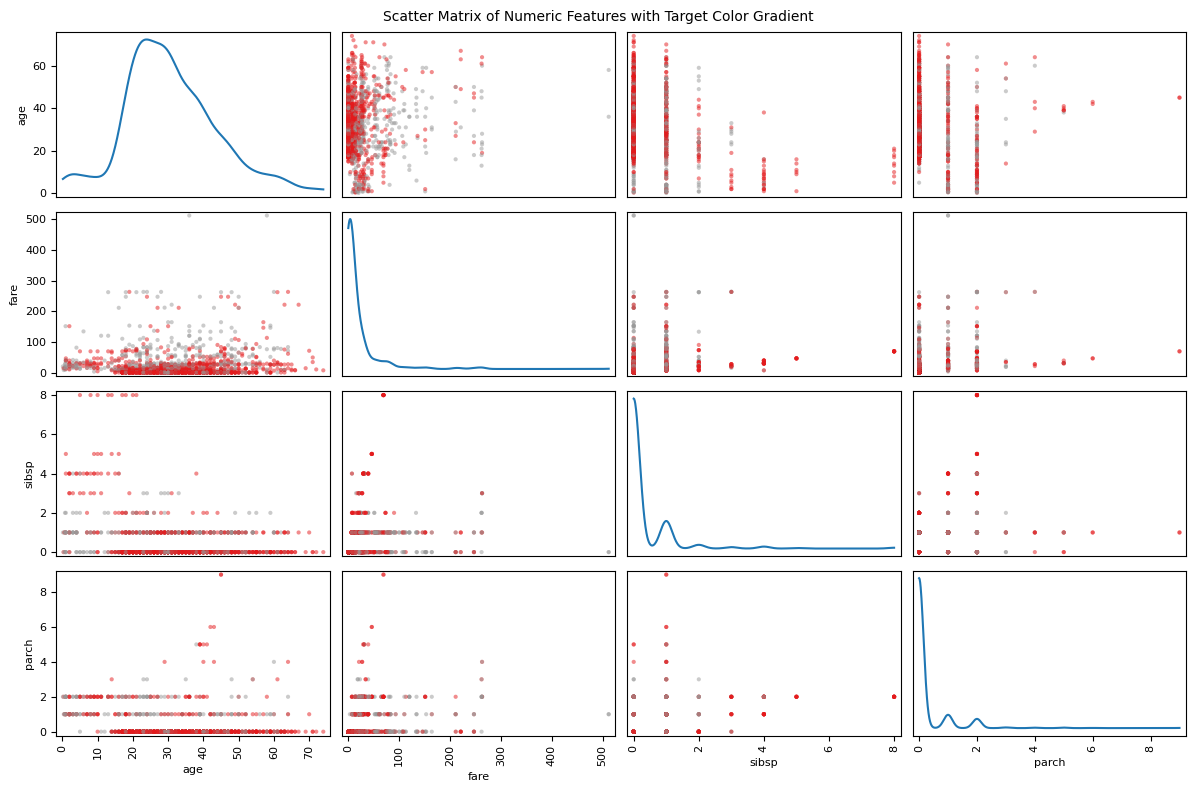

In [395]:
pd.plotting.scatter_matrix(numeric_df, figsize=(12,8),diagonal='kde', c=data['target'], cmap='Set1')
plt.suptitle('Scatter Matrix of Numeric Features with Target Color Gradient', fontsize=10)
plt.show()

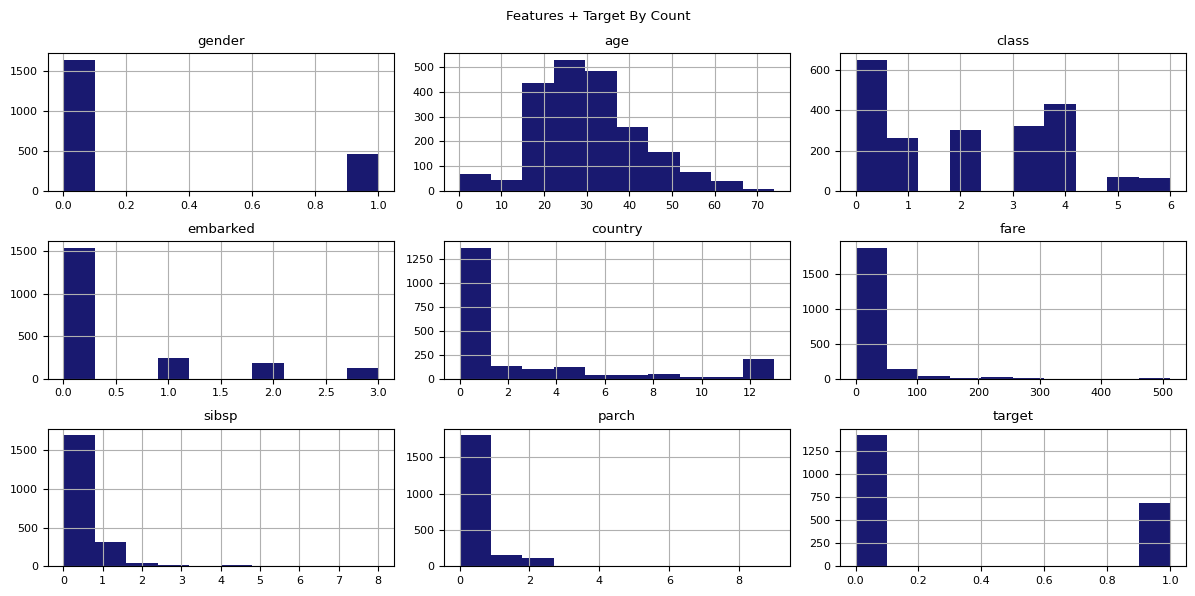

In [396]:
pd.plotting.hist_frame(data, figsize=(12,6), color='midnightblue')
plt.subplots_adjust(wspace=0.4, hspace=0.9)
plt.suptitle('Features + Target By Count')
None

#####  Outcome by Feature

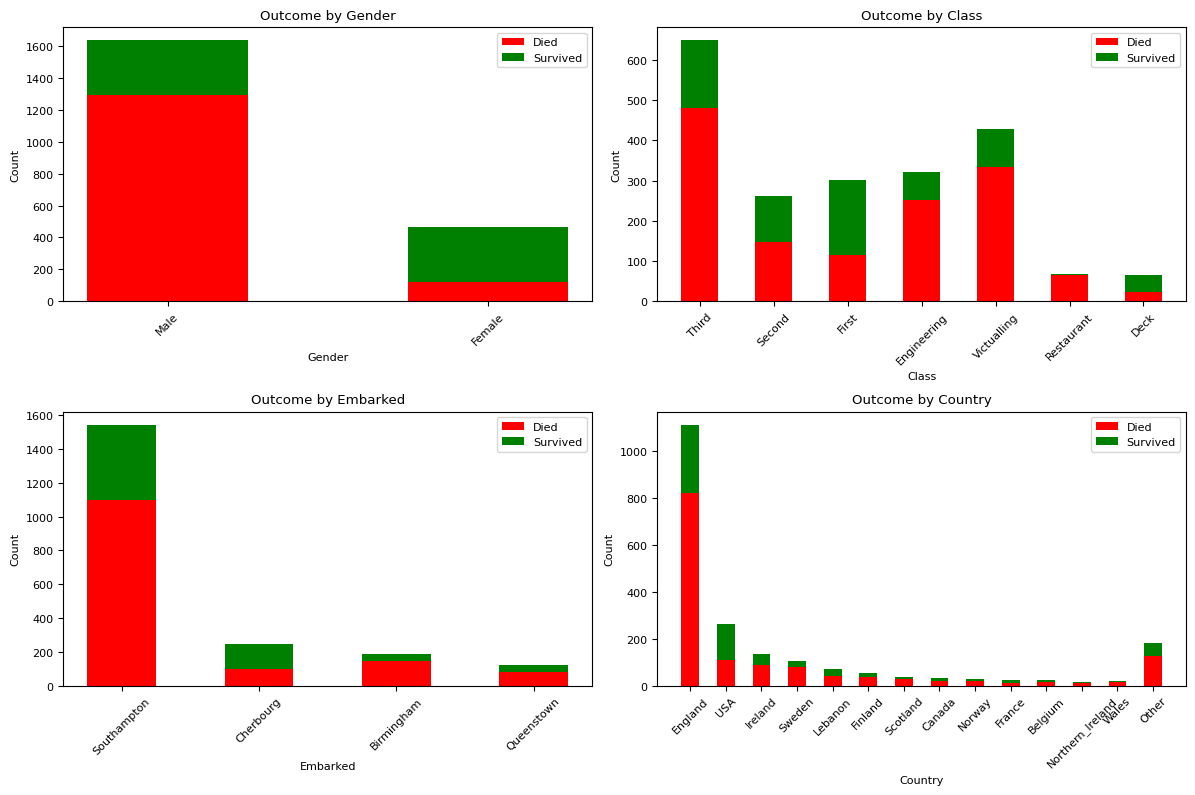

'CHRISTMAS COLORS !!!'

In [397]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

plot_index = 0
for feature in categorical_dict:
    if feature != 'target':
        plot_stacked_bar_chart(data, 
                               feature,
                               'target',
                               list(categorical_dict['target'].values()), 
                               list(categorical_dict[feature].values()),
                                ax=axes[plot_index],
                                colors =['r','g']
                                )
        plot_index += 1

plt.show()

'''CHRISTMAS COLORS !!!'''


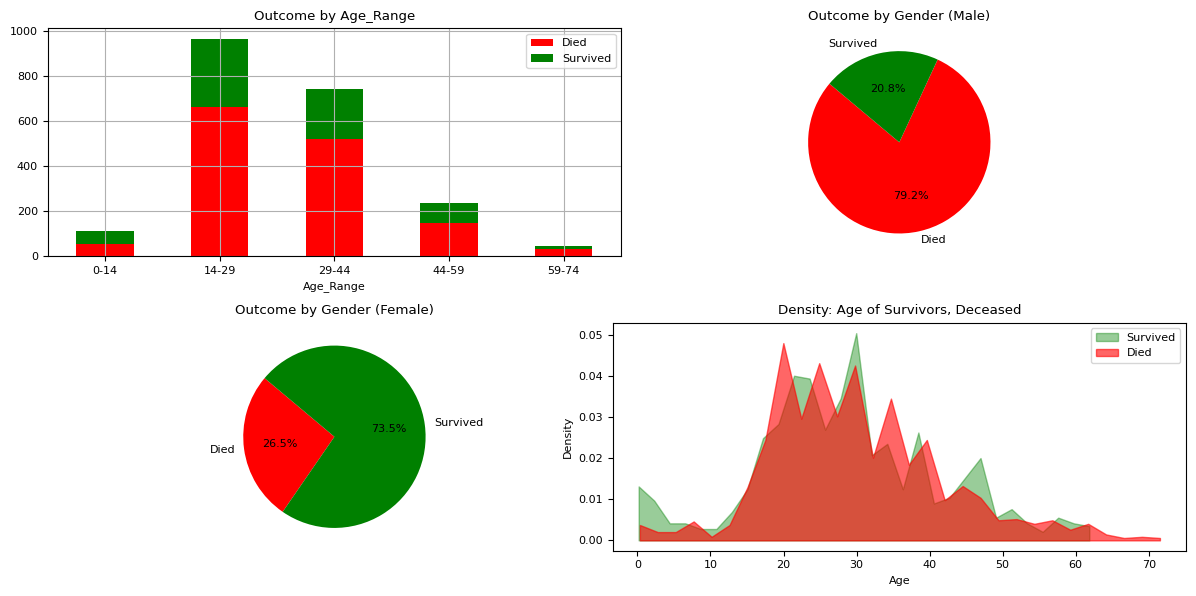

In [398]:
# --- figure and axes with 2 rows and 2 columns ---
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()  # Flatten fo iteration

# --- Stacked Bar Chart (on axes[0]) -------------------------------------------

num_bins = 5
bins = np.linspace(data['age'].min(), data['age'].max(), num_bins + 1)
age_labels = [f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins) - 1)]
data_plus_df = data.copy()
data_plus_df['Age_Range'] = pd.cut(data_plus_df['age'], bins=bins, labels=age_labels, right=False, duplicates='drop')
survival_counts = data_plus_df.groupby(['Age_Range', 'target'], observed=True).size().unstack()

survival_counts.plot(ax=axes[0], kind='bar', stacked=True, grid=True, color=['r', 'g'])
axes[0].set_xlabel('Age_Range')
axes[0].set_xticks(range(len(survival_counts.index)))
axes[0].set_xticklabels(survival_counts.index, rotation=0)
axes[0].set_title('Outcome by Age_Range')

handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, ['Died' if int(label) == 0 else 'Survived' for label in labels])

# --- Pie Charts (on axes[1] and axes[2]) --------------------------------------------------

grp1 = 'gender'
grp2 = 'target'
grp1_grp2_df = data.groupby([grp1, grp2]).size().unstack()
grp1_grp2_df = grp1_grp2_df.rename(columns=dict_target, index=dict_gender)

for i, ax in enumerate(axes[1:3]):  # Plot on axes[1] and axes[2]
    gender = grp1_grp2_df.index[i]
    ax.pie(grp1_grp2_df.loc[gender],
           labels=grp1_grp2_df.columns,
           autopct='%1.1f%%',
           startangle=140,
           colors=['r', 'g'])
    ax.set_title(f'Outcome by {grp1_grp2_df.index.name.title()} ({gender})')

# --- KDE plot (on axes[3]) ----------------------------------------
cond_surv = data.target == 1
cond_dead = data.target == 0

surv_age_df = data['age'][cond_surv]
density = np.histogram(surv_age_df, bins=30, density=True)
axes[3].fill_between(density[1][:-1], density[0], color="green", alpha=0.4, label='Survived')

died_age_df = data["age"][cond_dead]
density = np.histogram(died_age_df, bins=30, density=True)
axes[3].fill_between(density[1][:-1], density[0], color="red", alpha=0.6, label='Died')

axes[3].legend(['Survived', 'Died'])
axes[3].set_title('Density: Age of Survivors, Deceased')
axes[3].set_xlabel('Age')
axes[3].set_ylabel('Density')


plt.show()

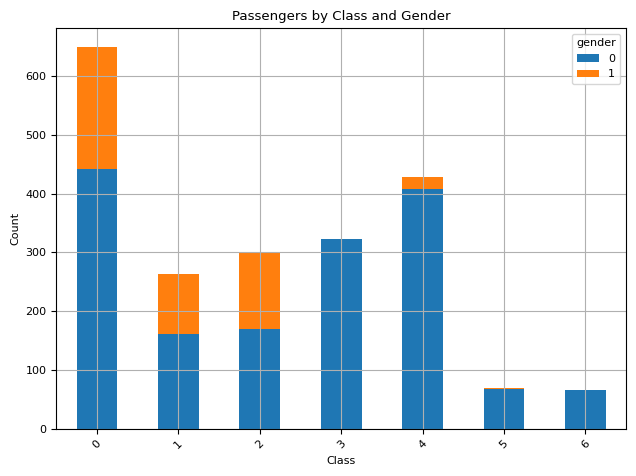

In [399]:

# Map the class and gender labels in the dataset
data1 = data.copy()
data1['class'] = data1['class'].map(dict_class)
data1['gender'] = data1['gender'].map(dict_gender)

# Create a pivot table for the stacked bar plot
pivot_table = data.pivot_table(index='class', columns='gender', values='target', aggfunc='count')

# Plot the stacked bar plot
pivot_table.plot(kind='bar', stacked=True)
plt.xlabel('Class')
plt.xticks(rotation = 45)
plt.ylabel('Count')
plt.title('Passengers by Class and Gender')
plt.grid(True)
plt.show()

#### YOUR ANSWERS HERE

<span style="color:magenta">
There's much to say but in the interest of brevity, there are a few things worth highlighting: 
<br>

1. Women were far more likely to survive than men (74% survival rate vs. 21%)

2. Those in First Class stood the best chance of survival, unsurprisingly. 

3. Survival rates declined as age group increased, meaning you had a better change of survival if you were under the age of 14 than in any other band. The worst survival rate was for those age 59+... slightly unexpected because I would assume older passengers were more likely to be in a better passenger class with a greater likelihood of survival..... but it was a pretty cold night. 

</span>

### Problem 4 (5 points)

#### Plot the correlation matrix of the numeric columns in the data set.
Which pair of different columns were highlighted as the most correlated?

##### Plot

In [400]:
# YOUR CODE HERE

corr_matrix = data.corr()
cols = corr_matrix.columns

### inefficient search for largest value in correlation matrix ### 
largest_corr = 0
largest_pair = (None, None)

for i in range(len(cols)):
    for j in range(i + 1, len(cols)): # using i + 1 to avoid including the diagonal elements
        corr = corr_matrix.iloc[i, j]
        if abs(corr) > abs(largest_corr):
            largest_corr = corr
            largest_pair = (cols[i], cols[j])

print(f'Columns w/ highest correlation: {largest_pair}, correlation = {largest_corr:.3f}')

Columns w/ highest correlation: ('gender', 'target'), correlation = 0.467


In [401]:
categorical_col_names = ['gender', 'class', 'embarked', 'country','target']
numeric_col_names = ['age', 'fare', 'sibsp', 'parch']

categorical_df = data[categorical_col_names]
numeric_df = data[numeric_col_names]

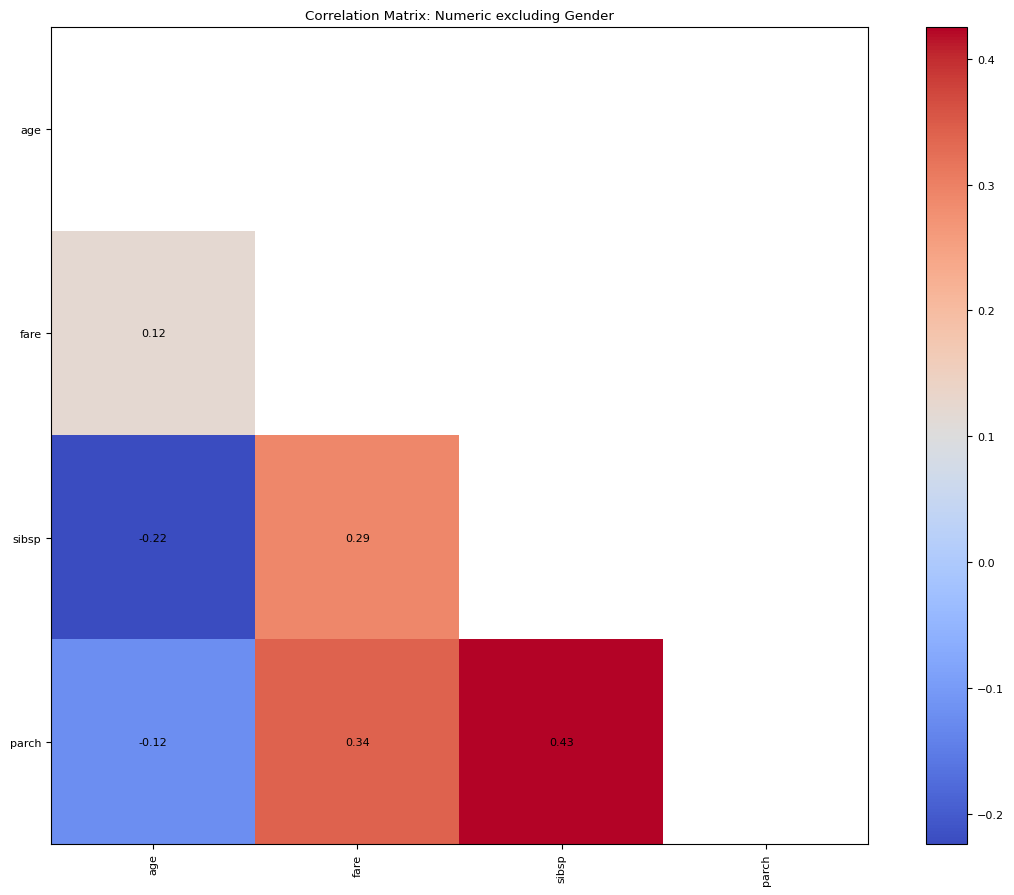

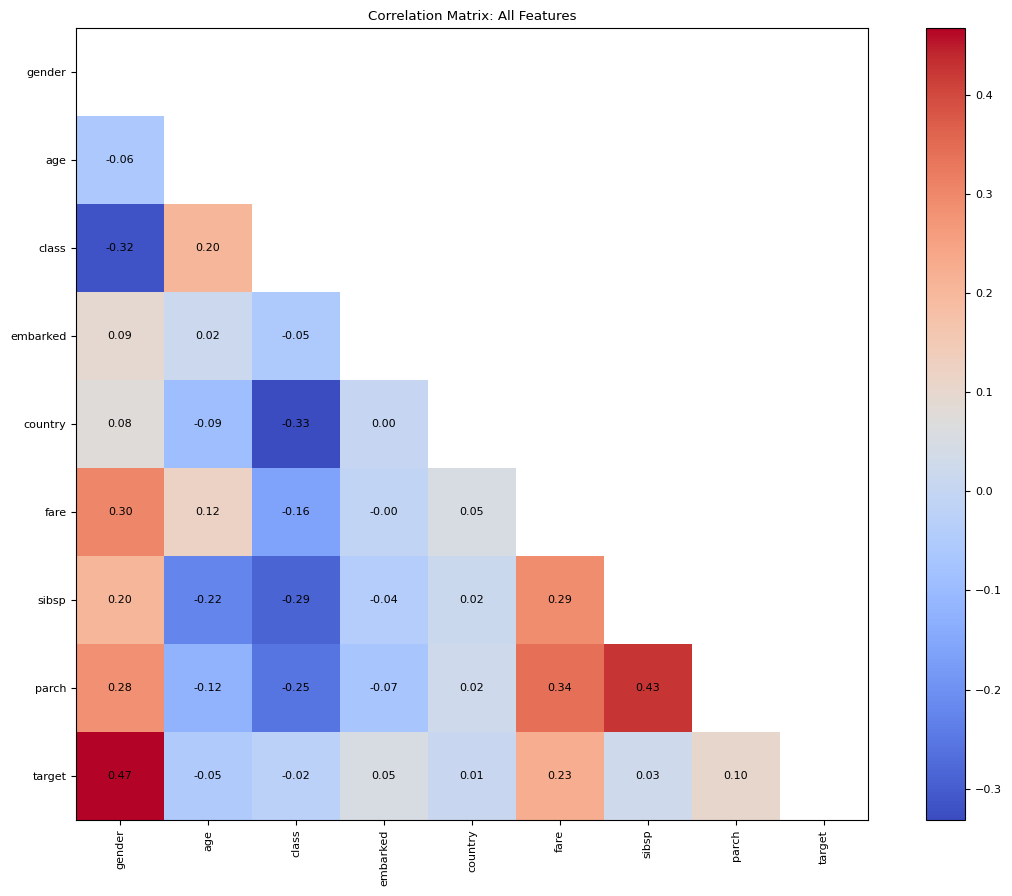

In [402]:
### Heatmap plot ####
dict_dfs = {'Numeric excluding Gender':numeric_df, 'All Features':data}

# fig, axs = plt.subplots(1, 2, figsize=(20, 6))

for key,val in dict_dfs.items():
    corr_matrix_heatmap(val, key)
plt.show()

#### YOUR ANSWERS HERE

<span style="color: magenta">
    
Some ambiguity here... if we consider 'numeric' features in the strictest sense, then we must <i>exclude gender</i>, in which case the strongest correlation is between number of <b>Parents/Children Aboard</b> and number of <b>Siblings/Children Aboard</b>, <b>(parch,sbsp) = 0.40</b>.
<br>
    
However, if Gender is included (even though it's a binary categorization), it is indisputably correlated to the survival outcome: <b>correlation = 0.464</b>.

</span>

### Problem 5 (10 points)

#### Pick three different regression model classes to try in problem 6 from the scikit-learn documentation.
For each class, provide a link to the scikit-learn documentation, and a link to another web page describing how that kind of model works.
The second link should not be from scikit-learn, but Wikipedia is acceptable.
You do not need to understand the methods at this time, but it is good to be comfortable researching them.

In [403]:
# YOUR CODE HERE

#### YOUR ANSWERS HERE

<span style="color: magenta">
<b>NOTE</b>

With the exception of logistic regression, I elected to explore the Titanic dataset with <b>classification models</b> because:
1. When I started this project, I was confused about the question wording
2. Applying linear regression to a binary classification problem felt conceptually invalid
3. It would be a tragedy to abandon all the code I've written. 
4. I have used an iterative set-up to generate different classes of models instead of doing each manually... it seemed wise initially until it led to too many custom functions that all had to be stored in the same notebook rather than as modules to import.

</span>


<b> Logistic Regression</b>

- [Ski-kit](https://scikit-learn.org/dev/modules/generated/sklearn.linear_model.LogisticRegression.html)

- [More](https://www.datacamp.com/tutorial/understanding-logistic-regression-python)

<b>Support Vector Classifier (SVC)</b>

- [Scikit-learn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)

- [More](https://www.spiceworks.com/tech/big-data/articles/what-is-support-vector-machine/)

<b>Random Forest Classifier</b><br>

- [Scikit-learn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)  

- [Explanation](https://www.datacamp.com/tutorial/random-forests-classifier-python)


<b>Gradient Boosting Classifier</b><br>

- [Scikit-learn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)  

- [Explanation](https://www.analyticsvidhya.com/blog/2021/09/gradient-boosting-algorithm-a-complete-guide-for-beginners/)


### Problem 6 (50 points)

#### Build three different regression models using the entire data set.
Plot the actual target vs the predicted values for each in one chart.
Compute the L2 and L1 losses for each of them.
You may use any regression class provided provided by scikit-learn, and you may reuse one class as long as you change its parameters enough to see different results.

In [404]:
# YOUR CODE HERE

y = data['target']
X = data.drop('target', axis=1)
print(f'Shape - X: {X.shape}, y: {y.shape}')

Shape - X: (2099, 8), y: (2099,)


In [405]:
#Instantiating models within a dictionary to iterate over

models = {
    'Logistic_Regression': LogisticRegression(max_iter = 10000),
    # 'Support_Vector_Machine': LinearSVC(max_iter=10000, dual=False),
    'Decision_Tree': DecisionTreeClassifier(),
    'Random_Forest': RandomForestClassifier(n_estimators = rndmfrst_estimators),
    'Gradient_Boosting': GradientBoostingClassifier()
}

#function calculate_metrics() appends to this dataframe !

results = pd.DataFrame(columns=['Model',
                                'Class',
                                'Training_Score',  
                                'Sensitivity_(TPR)', 
                                'Specificity_(TNR)', 
                                'Precision_(PPV)', 
                                'Accuracy', 
                                'Log_Loss', 
                                'F1',
                                'ROC_AUC',
                                'PR_AUC',
                                'L2_loss']
                      )


# This mapping is for grouping later...
model_types_map = {
    'LogisticRegression': 'LogisticRegression',
    'Logistic_Regression_kf': 'LogisticRegression',
    'Logistic_Regression_pipe': 'LogisticRegression',
    # 'LinearSVC': 'Support_Vector_Machine',
    # 'Support_Vector_Machine_kf': 'Support_Vector_Machine',
    # 'Support_Vector_Machine_pipe': 'Support_Vector_Machine',
    'DecisionTreeClassifier': 'DecisionTreeClassifier',
    'Decision_Tree_kf': 'DecisionTreeClassifier',
    'Decision_Tree_pipe': 'DecisionTreeClassifier',
    'RandomForestClassifier': 'RandomForestClassifier',
    'Random_Forest_kf': 'RandomForestClassifier',
    'Random_Forest_pipe': 'RandomForestClassifier',
    'GradientBoostingClassifier': 'GradientBoostingClassifier',
    'Gradient_Boosting_kf': 'GradientBoostingClassifier',
    'Gradient_Boosting_pipe': 'GradientBoostingClassifier'
}

In [406]:
'''train_test_split, Standard_Scaler, fit_transform'''

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = rndmst)
# X_train, X_test, y_train, y_test = preprocess_data(X, y)

/tmp/ipykernel_251269/2703958031.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, result_df],


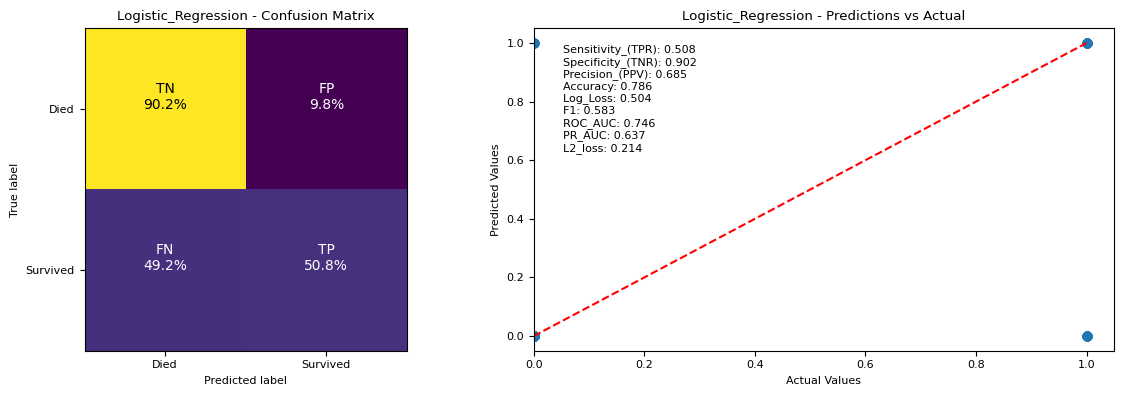

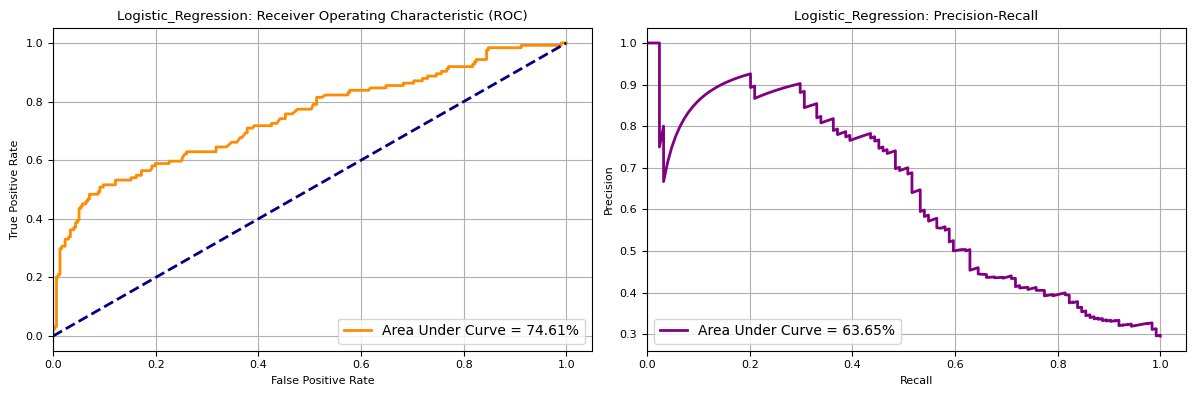

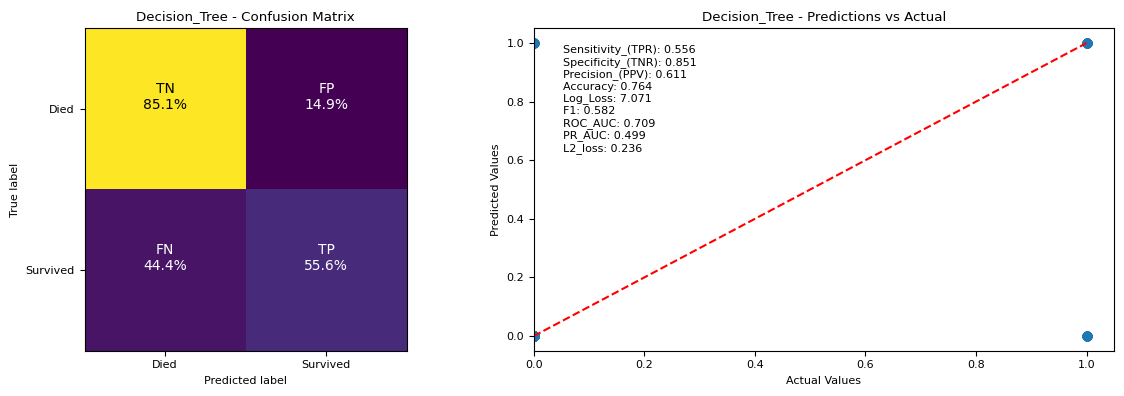

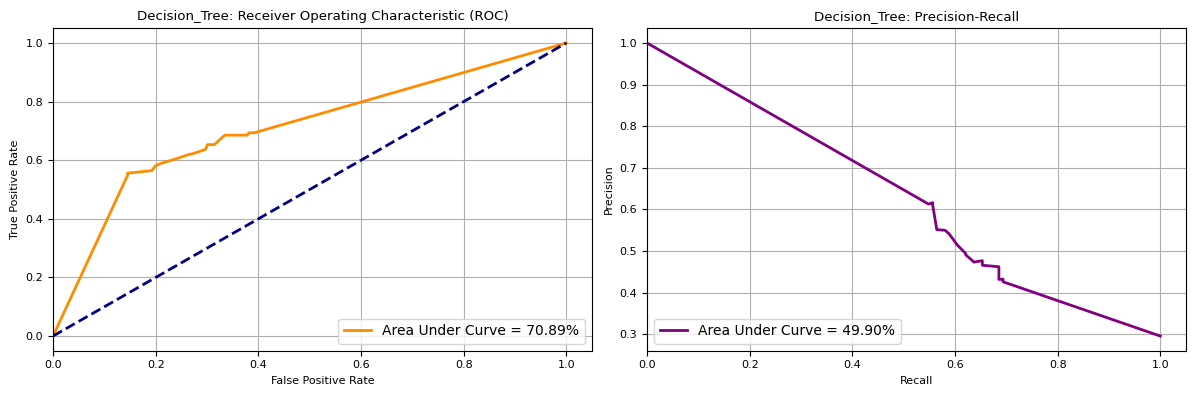

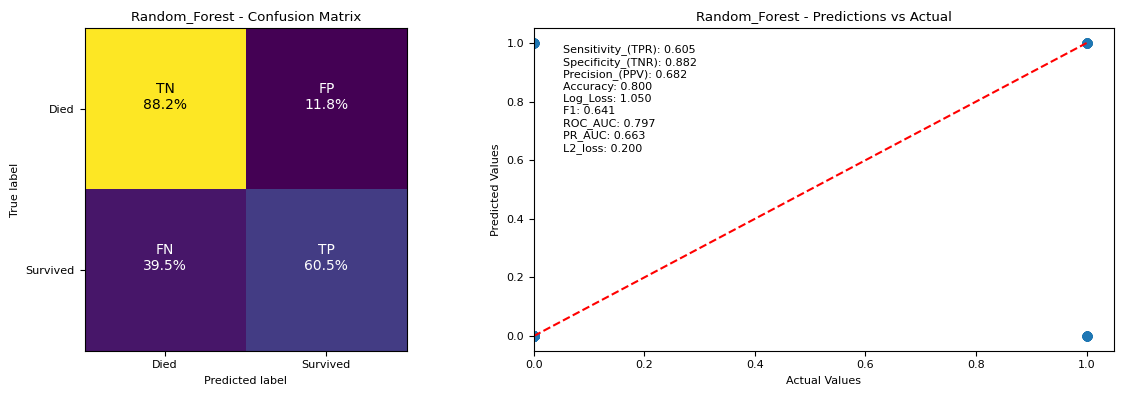

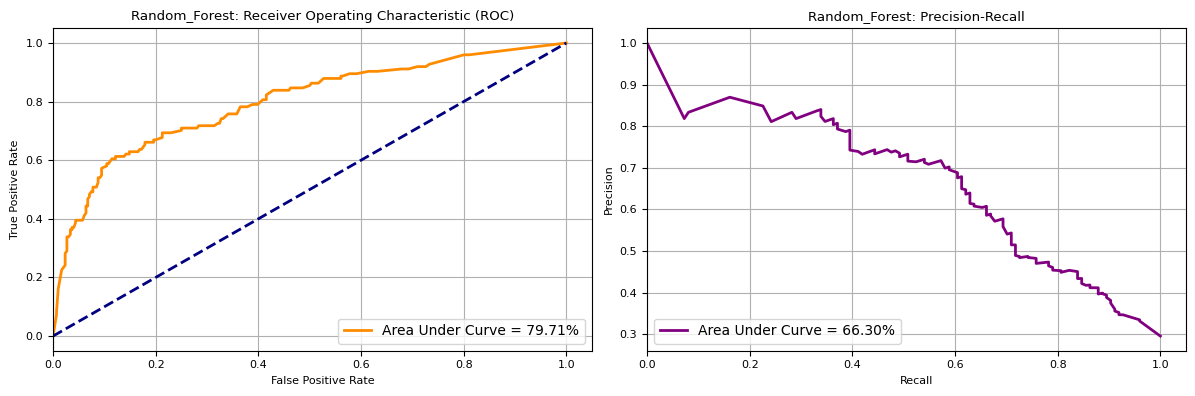

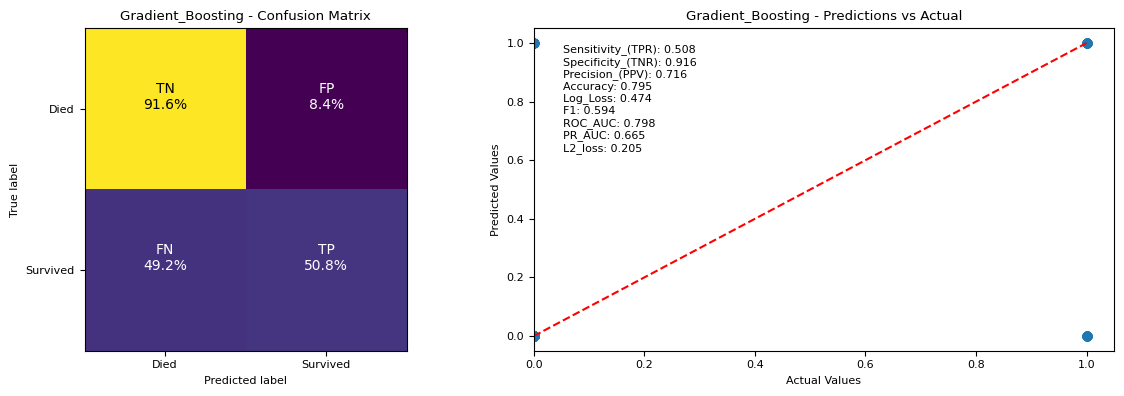

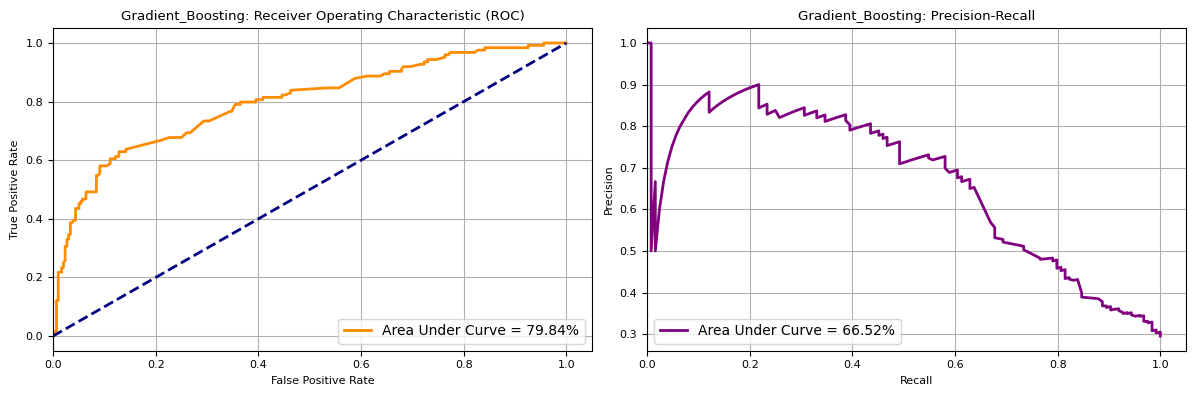

In [407]:
'''Iterate through the models and plots'''

for i, (name, model) in enumerate(models.items()):
    result_df, y_pred, y_pred_proba = evaluate_model(model, 
                                                     X_train, X_test, 
                                                     y_train, y_test)
    # print(result_df)
    # result_df = result_df.dropna(axis=1, how='all')  # Remove all-NA columns
    # result_df = result_df.loc[:, result_df.notna().any()]  # Remove all-NA rows
    results = pd.concat([results, result_df], 
                        ignore_index=True)
    
    plot_results(name, y_test, y_pred, result_df, list(dict_target.values()))

    if type(model).__name__ != 'LinearSVC':
        plot_roc_pr(name, y_test, y_pred_proba, grid=True)


# print(results)

In [408]:
results

,Model,Class,Training_Score,Sensitivity_(TPR),Specificity_(TNR),Precision_(PPV),Accuracy,Log_Loss,F1,ROC_AUC,PR_AUC,L2_loss
0,LogisticRegression,NaN,0.778440,0.508065,0.902027,0.684783,0.785714,0.503552,0.583333,0.746104,0.636532,0.214286
1,DecisionTreeClassifier,NaN,0.924955,0.556452,0.851351,0.610619,0.764286,7.070637,0.582278,0.708901,0.499040,0.235714
2,RandomForestClassifier,NaN,0.924360,0.604839,0.881757,0.681818,0.800000,1.049575,0.641026,0.797147,0.663027,0.200000
3,GradientBoostingClassifier,NaN,0.845742,0.508065,0.915541,0.715909,0.795238,0.474033,0.594340,0.798373,0.665184,0.204762


<!-- #### YOUR ANSWERS HERE -->

### Problem 7 (30 points)

#### Use 5-fold cross-validation to repeat building the same three kinds of regression models. 
Compare the L2 losses predicted by cross-validation against the L2 losses training against the whole data set. (The difference is likely from overfitting in the latter.)

In [409]:
# YOUR CODE HERE

'''Adding _kf to model names in models dictionary to indicate k-fold validation'''
models_kf = {key+'_kf':val for key,val in models.items()}

In [410]:
models_kf

{'Logistic_Regression_kf': LogisticRegression(max_iter=10000),
 'Decision_Tree_kf': DecisionTreeClassifier(),
 'Random_Forest_kf': RandomForestClassifier(n_estimators=50),
 'Gradient_Boosting_kf': GradientBoostingClassifier()}

In [411]:
## Using k-fold cross-validation, iterate through dict of models, generate scores and then add to results dataframe 

folds = 5
for i, (name, model) in enumerate(models_kf.items()):

    kf = KFold(n_splits = folds, shuffle = True, random_state = rndmst)

    scoring = {
        'CV_accuracy': 'accuracy',
        'CV_precision': 'precision',
        'CV_recall': 'recall',
        'CV_L2_loss': 'neg_mean_squared_error',
        'CV_F1_weighted': 'f1_weighted',
        'CV_ROC_AUC': 'roc_auc',
        'CV_PR_AUC': 'average_precision',
        'CV_Log_loss':'neg_log_loss'
    }

    cv_scores = cross_validate(model, X, y, cv=kf, scoring=scoring, return_train_score=True)
    cv_scores_avg = {key: np.mean(value) for key, value in cv_scores.items()}
    # print(name, "\n",cv_scores_avg, "\n--------------------\n")

    dict_cv_scores_avg = {
        'Model': [name],
        'Training_Score': cv_scores_avg['train_CV_accuracy'],
        'Sensitivity_(TPR)': cv_scores_avg['test_CV_recall'],
        'Precision_(PPV)': cv_scores_avg['test_CV_precision'],
        'Accuracy': cv_scores_avg['test_CV_accuracy'],
        'F1': cv_scores_avg['test_CV_F1_weighted'],
        'ROC_AUC': cv_scores_avg['test_CV_ROC_AUC'],
        'PR_AUC': cv_scores_avg['test_CV_PR_AUC'],
        'L2_loss': -cv_scores_avg['test_CV_L2_loss'],
        'Log_Loss': -cv_scores_avg['test_CV_Log_loss']
    }

    cv_scores_avg = pd.DataFrame(dict_cv_scores_avg)
    # print(cv_scores_avg)
    
    results = pd.concat([results, cv_scores_avg])   


In [412]:
# results

# Adding `Model_Type` column to `results_df`
results['Model_Type'] = results['Model'].map(model_types_map)
results = results.drop(columns=['Class'])

# Reordering columns
results = results[['Model', 'Model_Type'] + [col for col in results.columns if col not in ['Model', 'Model_Type']]]

results

,Model,Model_Type,Training_Score,Sensitivity_(TPR),Specificity_(TNR),Precision_(PPV),Accuracy,Log_Loss,F1,ROC_AUC,PR_AUC,L2_loss
0,LogisticRegression,LogisticRegression,0.778440,0.508065,0.902027,0.684783,0.785714,0.503552,0.583333,0.746104,0.636532,0.214286
1,DecisionTreeClassifier,DecisionTreeClassifier,0.924955,0.556452,0.851351,0.610619,0.764286,7.070637,0.582278,0.708901,0.499040,0.235714
2,RandomForestClassifier,RandomForestClassifier,0.924360,0.604839,0.881757,0.681818,0.800000,1.049575,0.641026,0.797147,0.663027,0.200000
3,GradientBoostingClassifier,GradientBoostingClassifier,0.845742,0.508065,0.915541,0.715909,0.795238,0.474033,0.594340,0.798373,0.665184,0.204762
0,Logistic_Regression_kf,LogisticRegression,0.782515,0.501414,NaN,0.737622,0.779894,0.504471,0.766771,0.766814,0.689192,0.220106
0,Decision_Tree_kf,DecisionTreeClassifier,0.927942,0.540729,NaN,0.670069,0.763706,6.623178,0.756381,0.721820,0.553303,0.236294
0,Random_Forest_kf,RandomForestClassifier,0.926870,0.559685,NaN,0.700440,0.778943,0.988692,0.771635,0.788744,0.709094,0.221057
0,Gradient_Boosting_kf,GradientBoostingClassifier,0.844212,0.533899,NaN,0.790721,0.802770,0.458611,0.790758,0.815906,0.746399,0.197230


#### YOUR ANSWERS HERE

<span style="color:magenta">
This problem was sinister because I went down the Classification path. Different models, different metrics, endless conditionals in my code, which I hoped would be robust enough to handle any model class.<br>

<b>APPROACH</b>

The loop in the previous cell may not be pretty but the calculations are thoughtful. The hardest parts were:
- knowing which arguments I could pass to the scoring parameter in the `cross_validate` function. Depends on the estimator, and the string values aren't always the same as for `cross_val_score`. And the official documentation is lacking; there are more than 50 arguments you can pass to that parameter, most of which are poorly described. 

- Adding my results to the dataframe of results from problem 6. Thumbs down. 

- For Training_Score, I am using the mean of the cross validation accuracy score for the *training* set. All other scores are drawn from the arrays of *test* scores. 

- No confusion matrix. Each fold generates a confusion matrix; aggregating into a single confusion matrix would be rather involved and require a framework for weighting each matrix value in each fold when computing an aggregate value. To my knowledge, skikit-learn doesn't have a function to do this. 

See below for a complete comparison of cross-validation results against the single-split scores from Problem 6.  
        
</span>

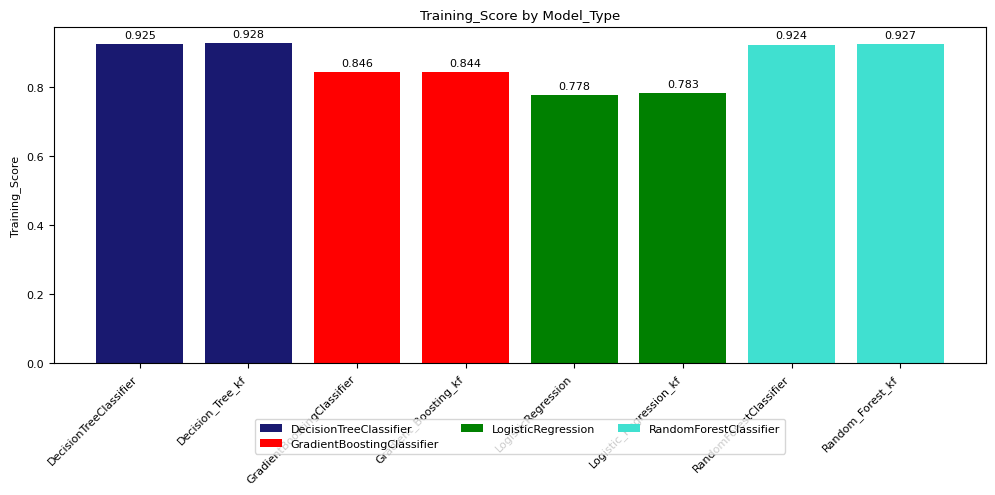

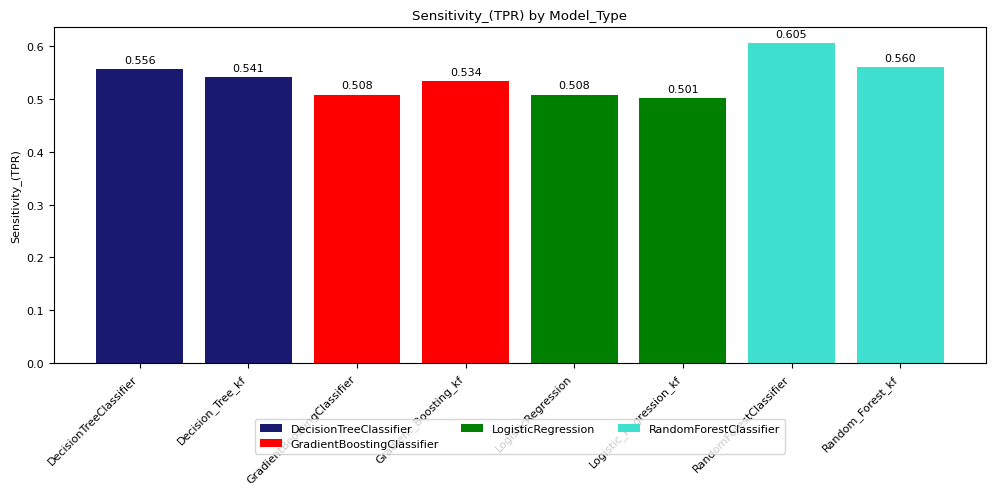

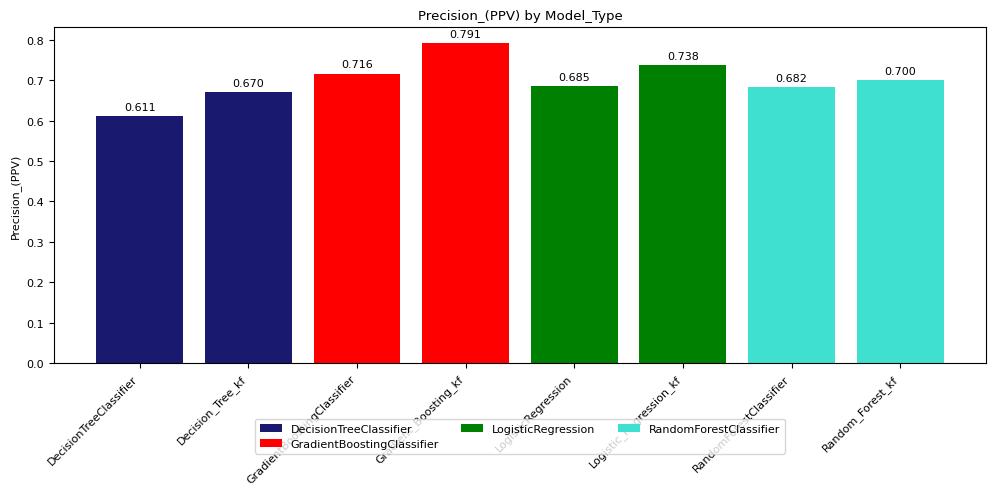

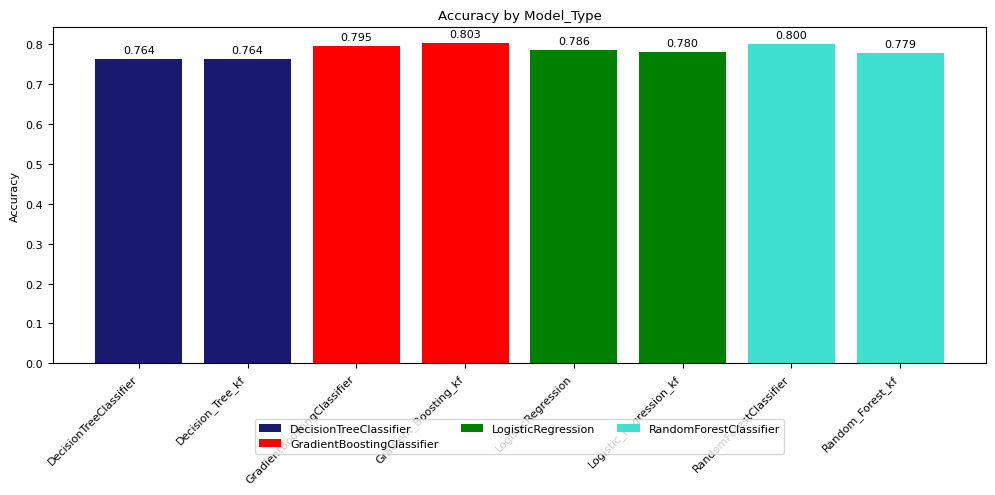

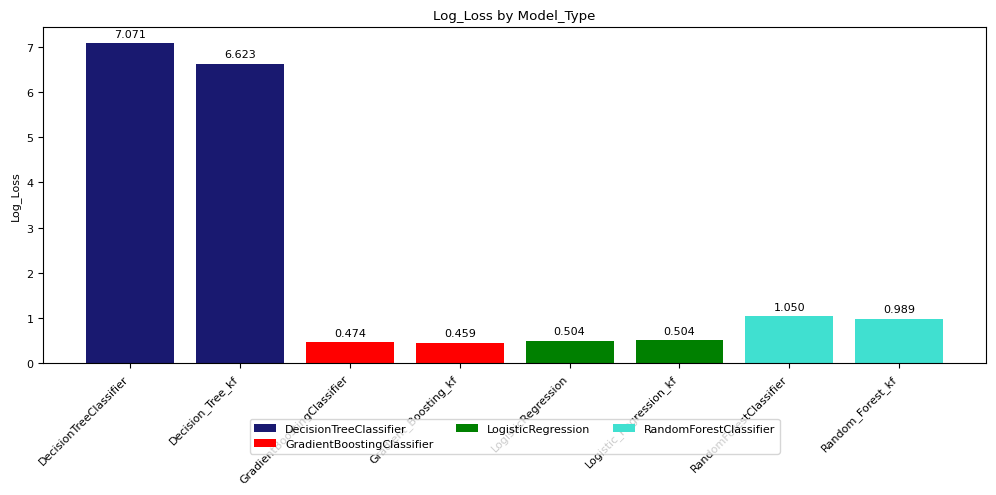

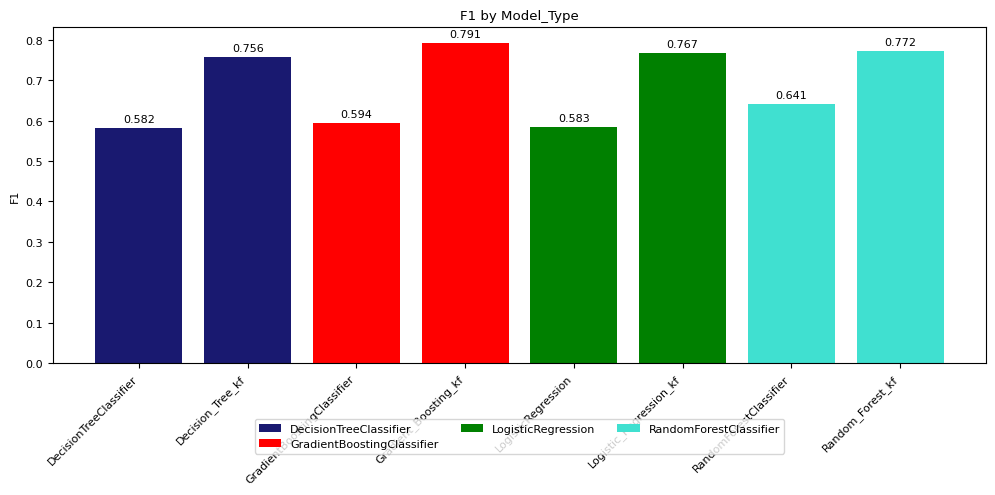

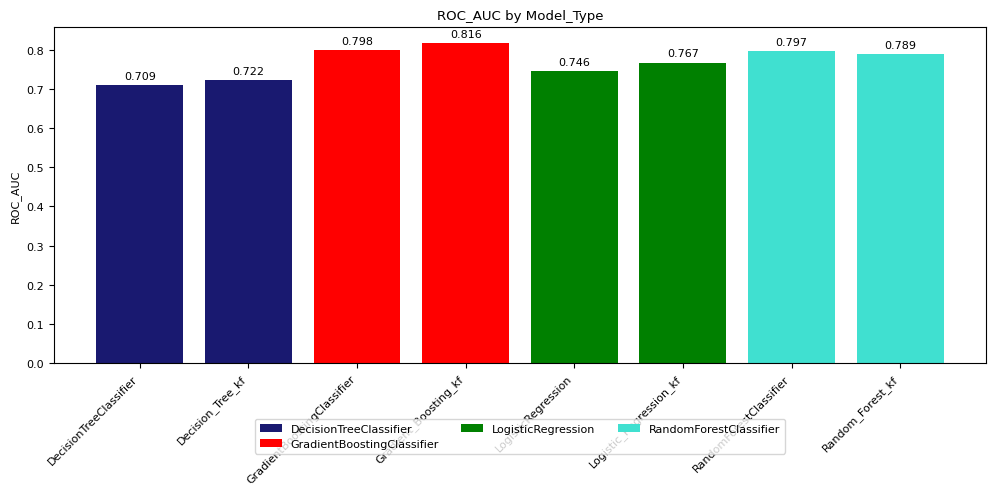

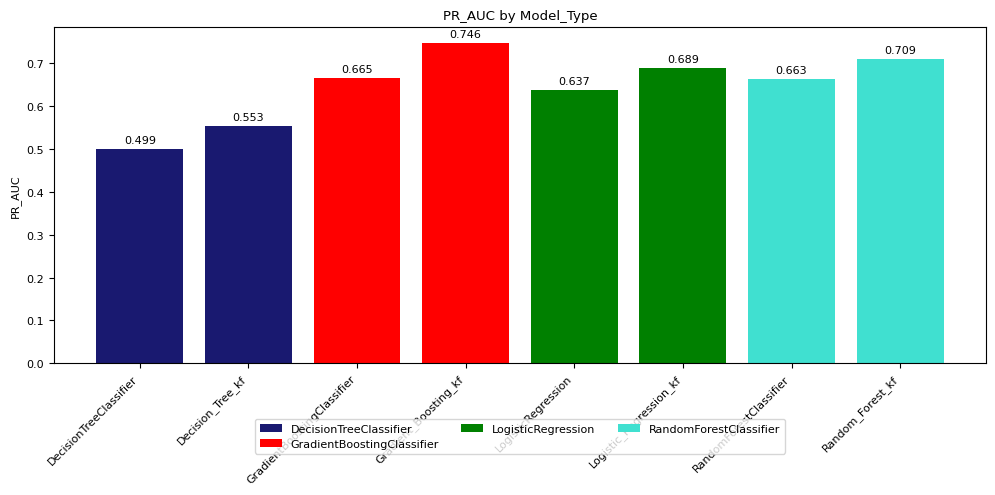

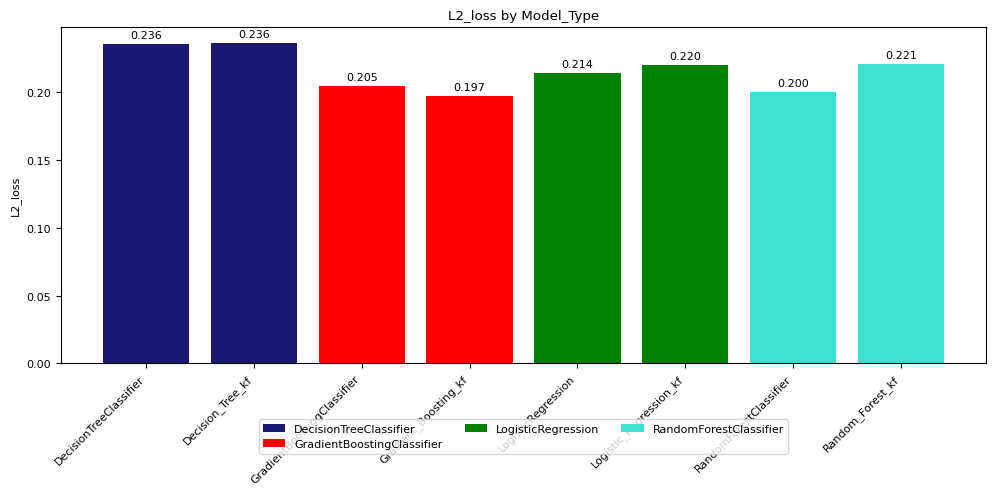

In [413]:
exclude_columns = ['Model', 'Model_Type','Specificity_(TNR)']
filtered_columns = [col for col in results.columns if col not in exclude_columns]
for col in filtered_columns:
    plot_bar_group_metric(results,'Model_Type',col)


### Problem 8 (25 points)

#### Build three different regression models as in problem 6, but preprocess the data so that each column has mean zero and standard deviation one first.
For full credit, use a scikit-learn pipeline for each model.
For each model, compare the L2 losses -- which of them performed differently from your results in problem 6?

(This process will be covered in week 13.)

In [414]:
models_pipelines = {
    f'{name}_pipe': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    for name, model in models.items()
}
# models_pipelines

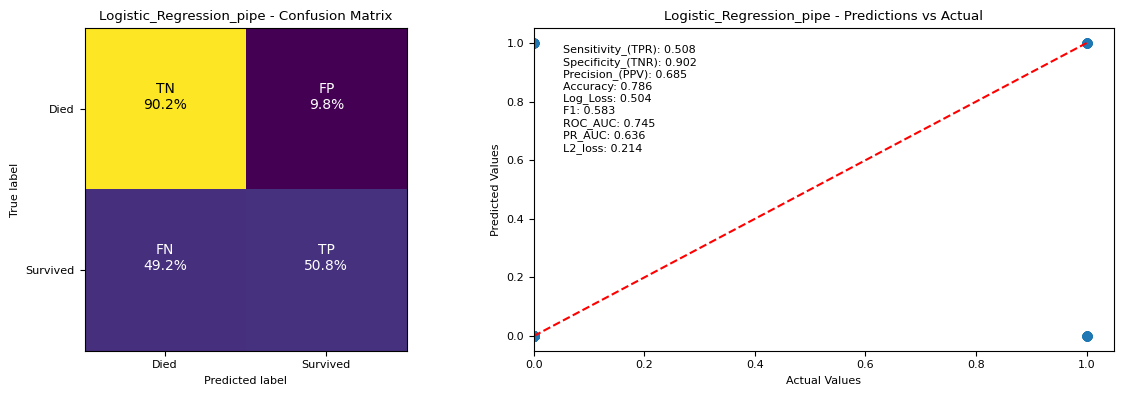

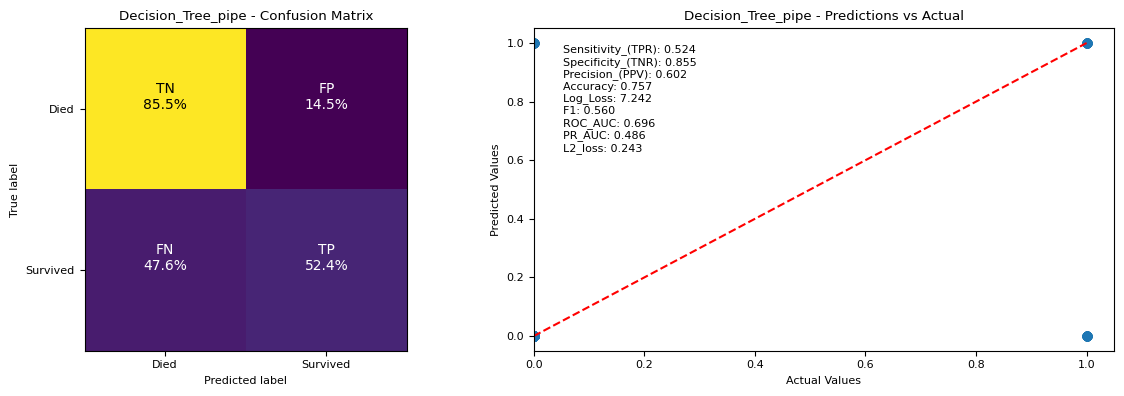

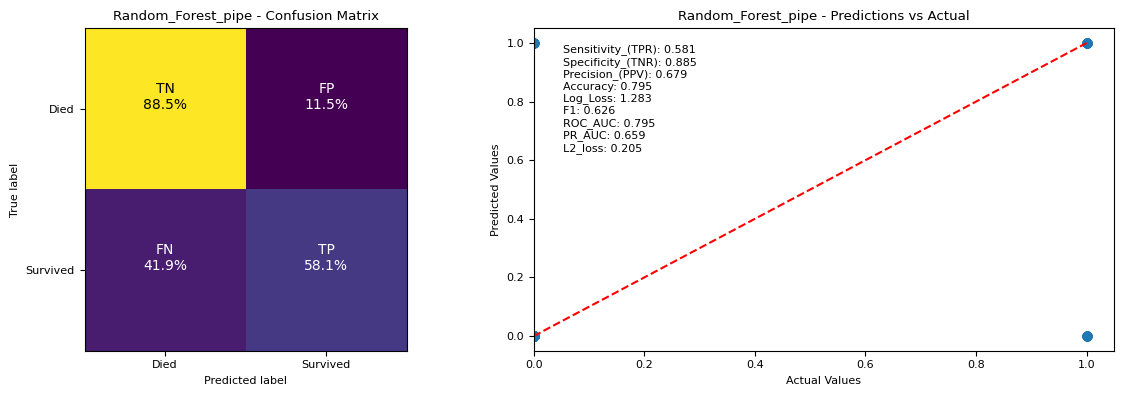

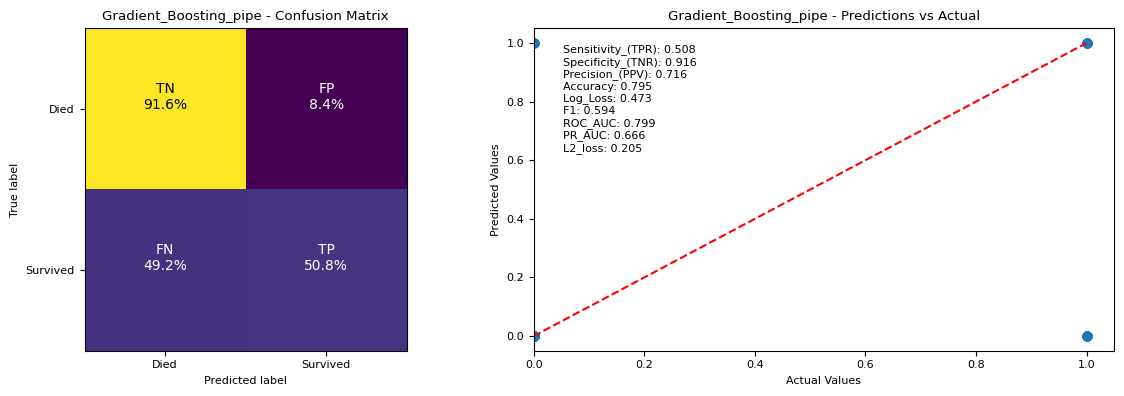

In [415]:
for name, pipeline in models_pipelines.items():
    result_df, y_pred, y_pred_proba = evaluate_model_pipeline(pipeline, X, y)

    result_df['Model'] = name

    results = pd.concat([results, result_df], ignore_index=True)
    results['Model_Type'] = results['Model'].map(model_types_map)
    plot_results(name, y_test, y_pred, result_df, list(dict_target.values()))

    # plot_roc_pr(name, y_pred, y_pred_proba, grid = False)
    # break


In [416]:
results

,Model,Model_Type,Training_Score,Sensitivity_(TPR),Specificity_(TNR),Precision_(PPV),Accuracy,Log_Loss,F1,ROC_AUC,PR_AUC,L2_loss
0,LogisticRegression,LogisticRegression,0.778440,0.508065,0.902027,0.684783,0.785714,0.503552,0.583333,0.746104,0.636532,0.214286
1,DecisionTreeClassifier,DecisionTreeClassifier,0.924955,0.556452,0.851351,0.610619,0.764286,7.070637,0.582278,0.708901,0.499040,0.235714
2,RandomForestClassifier,RandomForestClassifier,0.924360,0.604839,0.881757,0.681818,0.800000,1.049575,0.641026,0.797147,0.663027,0.200000
3,GradientBoostingClassifier,GradientBoostingClassifier,0.845742,0.508065,0.915541,0.715909,0.795238,0.474033,0.594340,0.798373,0.665184,0.204762
4,Logistic_Regression_kf,LogisticRegression,0.782515,0.501414,NaN,0.737622,0.779894,0.504471,0.766771,0.766814,0.689192,0.220106
5,Decision_Tree_kf,DecisionTreeClassifier,0.927942,0.540729,NaN,0.670069,0.763706,6.623178,0.756381,0.721820,0.553303,0.236294
6,Random_Forest_kf,RandomForestClassifier,0.926870,0.559685,NaN,0.700440,0.778943,0.988692,0.771635,0.788744,0.709094,0.221057
7,Gradient_Boosting_kf,GradientBoostingClassifier,0.844212,0.533899,NaN,0.790721,0.802770,0.458611,0.790758,0.815906,0.746399,0.197230
8,Logistic_Regression_pipe,LogisticRegression,0.779035,0.508065,0.902027,0.684783,0.785714,0.504378,0.583333,0.744987,0.636278,0.214286
9,Decision_Tree_pipe,DecisionTreeClassifier,0.924955,0.524194,0.854730,0.601852,0.757143,7.241588,0.560345,0.696382,0.485587,0.242857


In [417]:
# results.to_csv(f'model_results.csv', index=False)

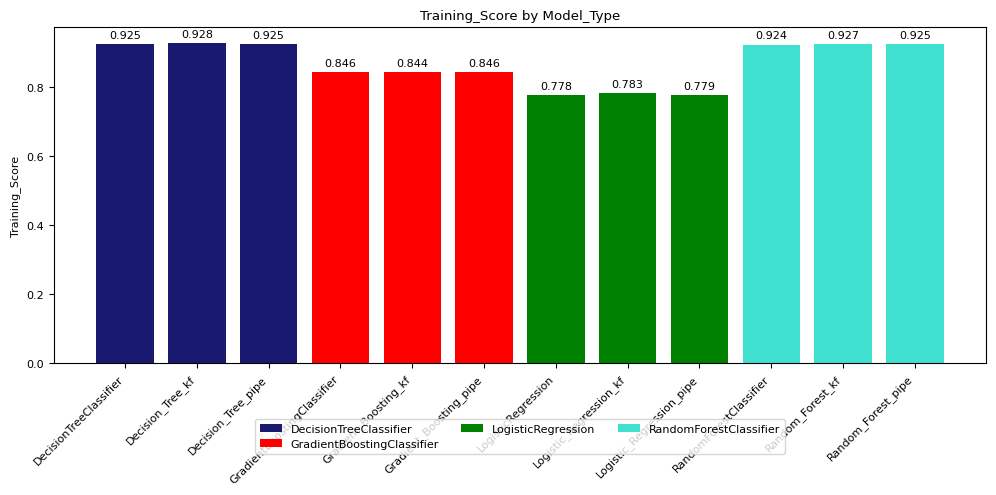

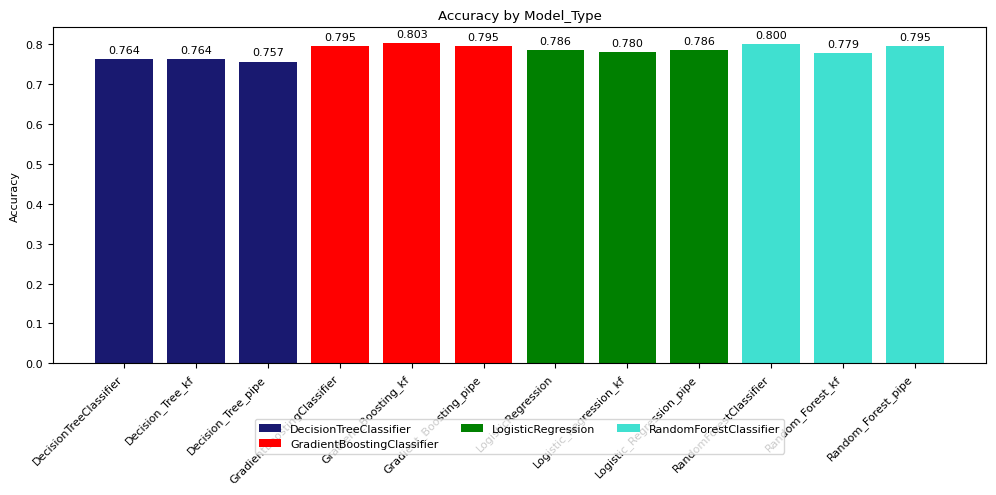

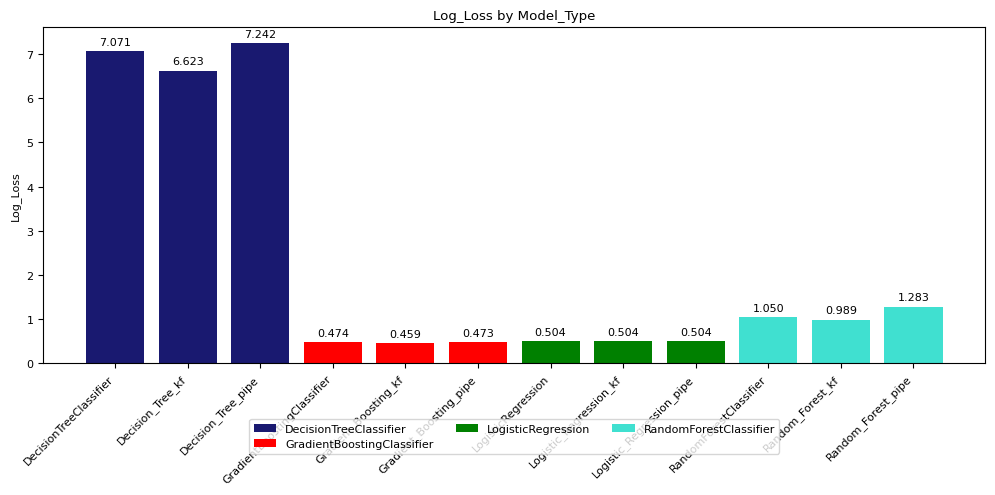

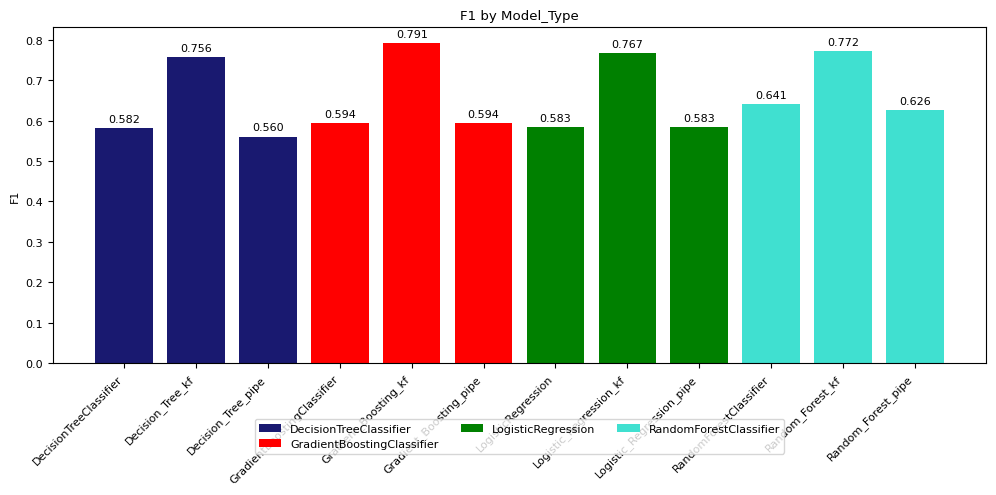

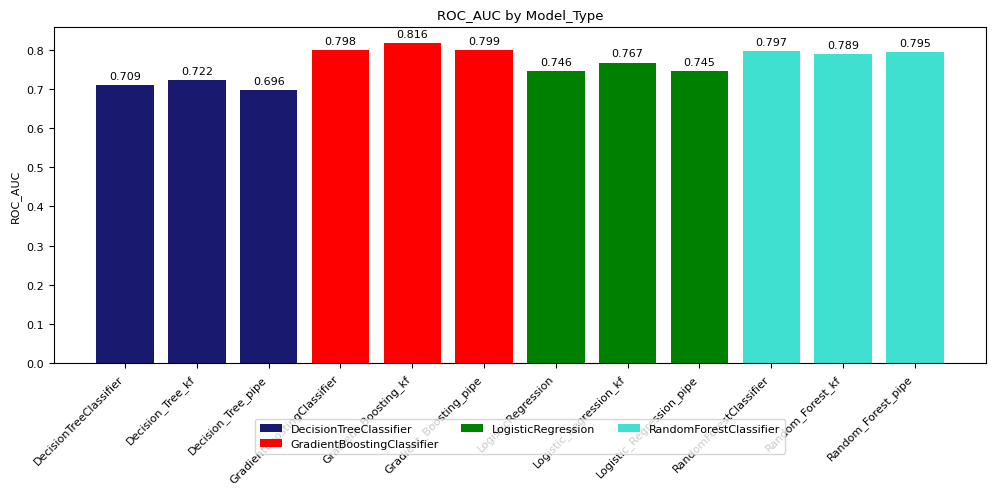

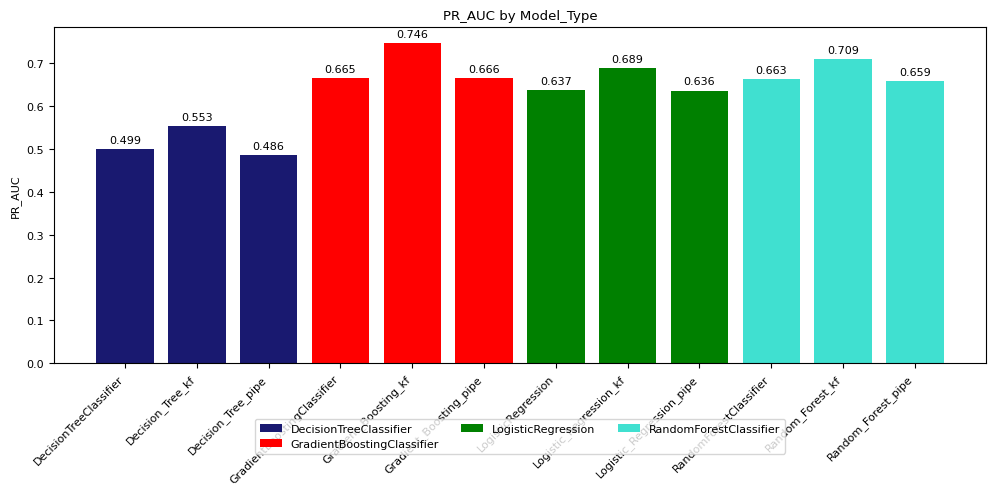

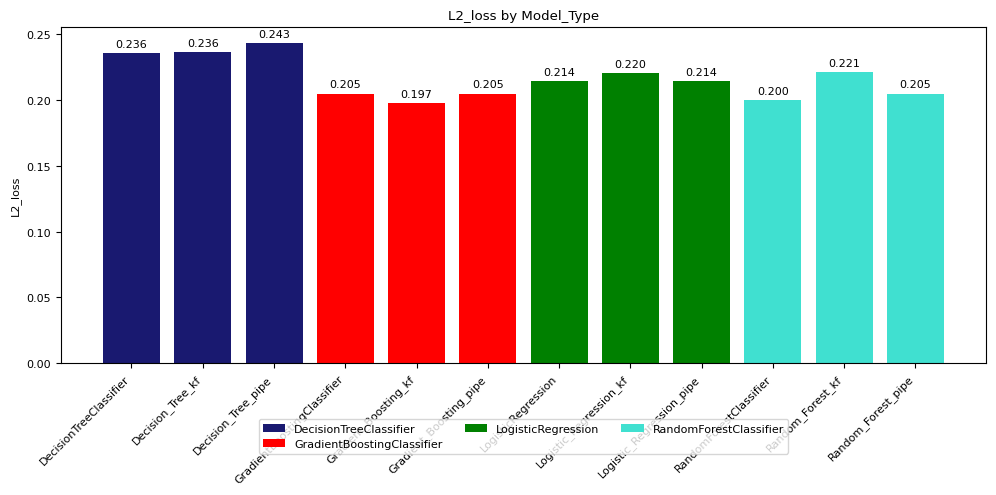

In [418]:
exclude_columns = ['Model', 'Model_Type', 'Sensitivity_(TPR)', 'Specificity_(TNR)', 'Precision_(PPV)']
filtered_columns = [col for col in results.columns if col not in exclude_columns]
for col in filtered_columns:
    plot_bar_group_metric(results,'Model_Type',col)

#### YOUR ANSWERS HERE

<span style='color:magenta'>
<h5>General Observations</h5>

- Data splitting: in non-pipeline approaches, we scale the training and testing data separately. Consequently, the scaler was fit on the entire dataset <i>before</i> the split, potentially introducing info leakage from  test set into training set. With pipelines, scaler is fit only on the training data within each cross-validation fold, which is preferable.

- Randomness in models: Some models like RandomForestClassifier have inherent randomness due to the random selection of features and data points. Even with the same random state, the exact results might vary slightly due to different data splitting and scaling procedures.

- Numerical precision: small differences in results due to numerical precision and rounding error.

<h5>Assessment</h5>

- With respect to L2 Loss, only the DecisionTree and RandomForest classifiers benefitted from using the scaler pipeline; there were no meaningful improvements for the other model classes. 

- In theory, Mean Squared Error shouldn't really change much at all after implementing a pipeline that normalizes/standardizes. In P6, I did not standardize the data prior to fitting the models.   

- I have removed the ROC and PR curves from Problem 8 because, for whatver reason, after scaling the data, I get nonsensical values, in part b/c the lengths of the FPR, TPR and Thresholds are unequal, which might be related to interpolation, but I will revisit that in 2025.

</span>

### Problem 9 (5 points)

#### A colleague suggests that you find better models by repeatedly building decision trees with random depth limits.
They say that trying 1000 such models will likely find an improvement as long as you use cross validation.
Give a one sentence response to this suggestion. ""

#### YOUR ANSWERS HERE

<span style="color: magenta">
While increasing model diversity can improve model performance, relying only on repeating decision trees with random depth limits is inefficient and poses significant risk of overfitting, even when cross-validation is used; we are more likely to achieve better overall performance using ensemble methods like Random Forest and Gradient Boosting. 

</span>

### Problem 10 (10 points)

#### Pick a best model from all the models that you built and otherwise described in this project.
Explain how you picked it, including what criteria you chose, and how the other models compared by that criteria.
As much as possible, justify that problem in the context of the original data set. 

In [419]:
# 2-column grid for bar subplots 
# numeric_cols = [col for col in results_df.columns if results_df[col].dtype in ['int64', 'float64']]
num_cols = 2
# cols = [col for col in results_df.columns[2::]]
cols_scores = ['Training_Score', 
               'Sensitivity_(TPR)',
               'Specificity_(TNR)',
               'Precision_(PPV)',
               'Accuracy',
               'F1',
               'ROC_AUC',
               'PR_AUC'
              ]


cols_loss = ['Log_Loss','L2_loss']

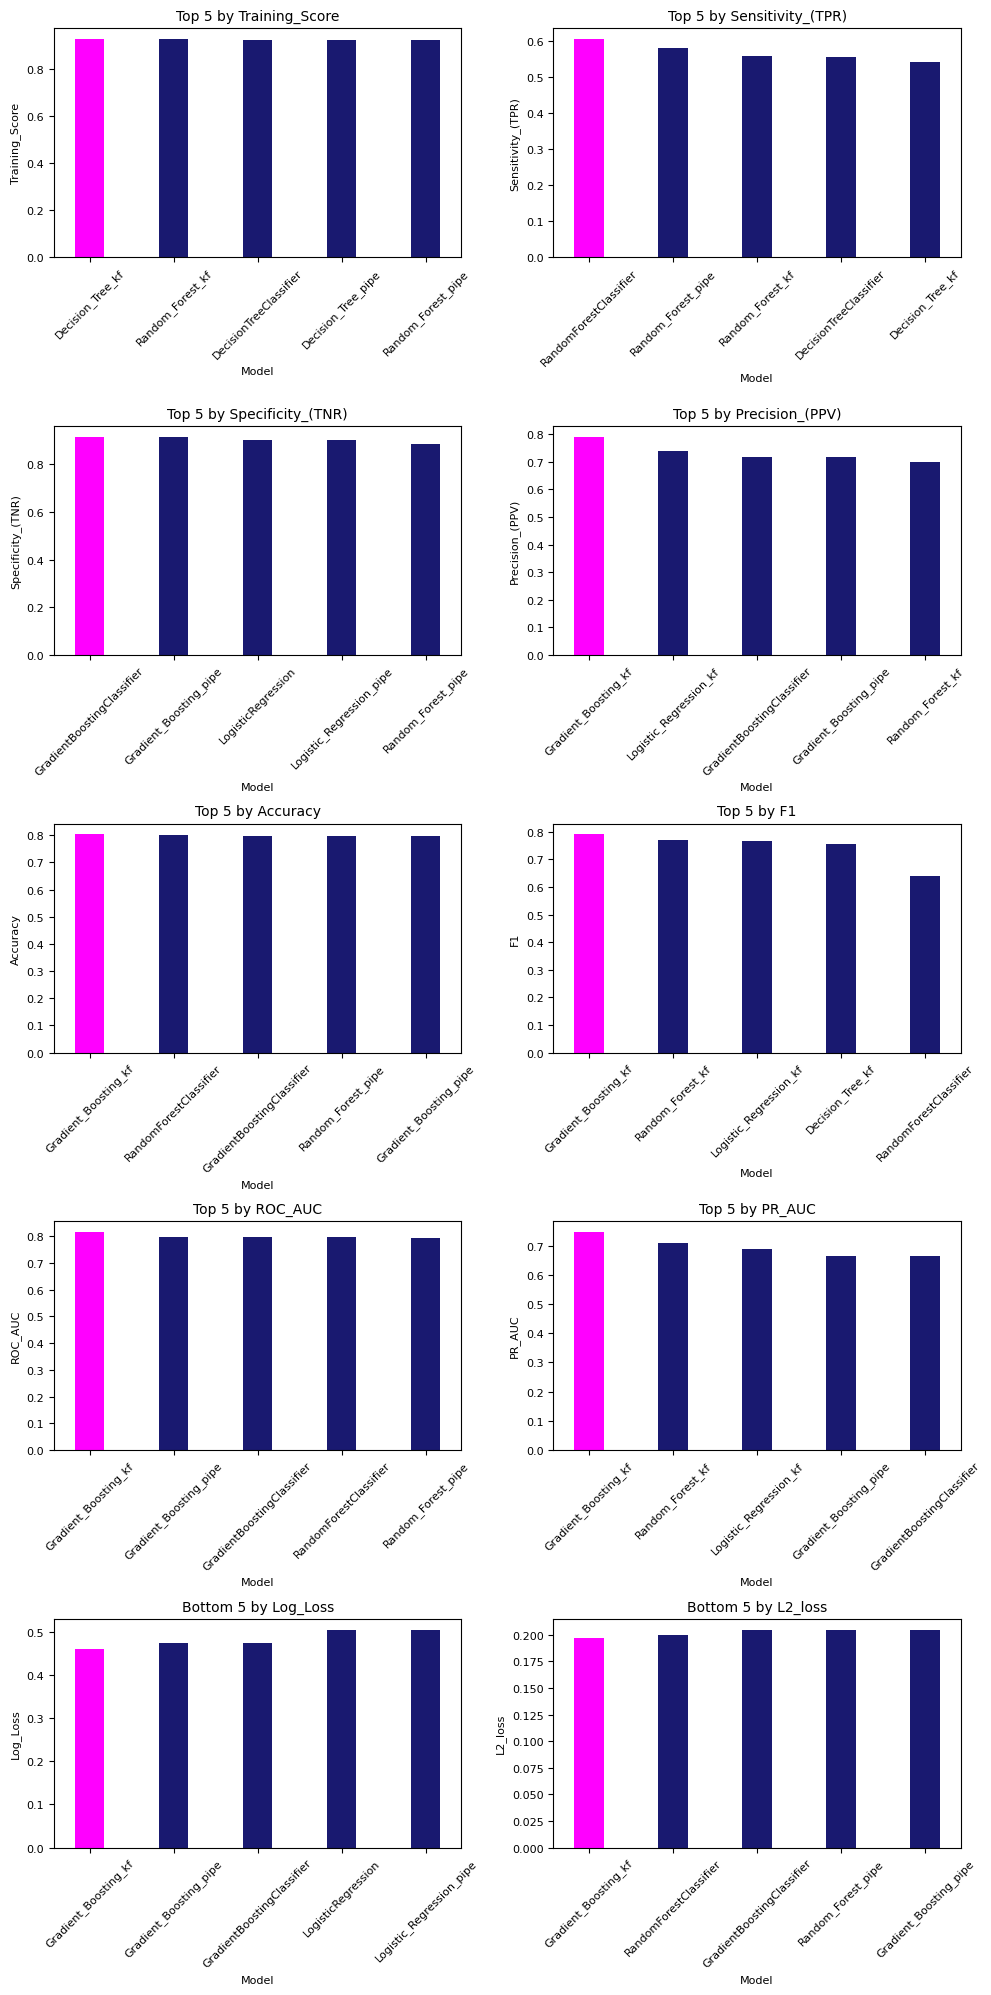

In [420]:
num_rows = math.ceil((len(cols_scores) + len(cols_loss)) / num_cols)
# print(num_rows)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 4))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Loop through columns and plot in grid
for i, col in enumerate(cols_scores):
    plot_top_bottom_arun(results, col, axes[i], top=True, n_values=5)

offset = len(cols_scores)  # Calculate the offset for cols_loss
for i, col in enumerate(cols_loss):
    plot_top_bottom_arun(results, col, axes[i + offset], top=False, n_values=5)

# Hide any unused subplots
for i in range(len(cols_scores) + len(cols_loss), len(axes)):
    axes[i].axis('off')

plt.show()

<span style="color:magenta">

- The unusual Log Loss values for the DecisionTree RandomForest classifiers models might be b/c the predicted probabilities haven't been calibrated with Platt scaling or Isotonic; For instance, unpruned DecisionTree and RandomForest models tend to drive predicted probabilities toward 0 or 1, and if there are errors, they get magnified.

</span>

#### YOUR ANSWERS HERE

<span style="color:magenta">

The GradientBoostingClassifier model appears to be the best-performing model among those evaluated.


1. Evaluation Metric

- These are Classification models, so 'Accuracy' should be the primary evaluation metric, where 'Accuracy' represents the proportion of passengers correctly classified as either survivors or non-survivors-- in other words, the True Positive and True Negative rates.

- As the bar plots above demonstrate, the GradientBoostingClassifier, especially when using a 5-fold cross validation, delivers the highest accuracy (approximately 80%) among the models tested. Accordingly, GradientBoosting classification also yields the highest F1 and lowest Log-Loss and L2 Loss scores, which seems logical. 

3. Additional Considerations:

- While accuracy serves as a good starting point, it's important to consider other metrics, such as sensitivity, specificity, and F1-score, especially when dealing with imbalanced datasets. In the context of the Titanic dataset, sensitivity would indicate the model's ability to correctly identify survivors, while specificity would indicate its ability to correctly identify non-survivors. Frankly, the F1 score makes the most sense, but I wasn't sure how to weight it for this exercise. 

</span>